Max DrawDown

In [ ]:
import pandas as pd

def calculate_max_drawdown(series):
    # Calcul du sommet historique glissant
    roll_max = series.cummax()
    # Calcul du drawdown quotidien
    drawdown = (series - roll_max) / roll_max
    # Le Maximum Drawdown est le minimum de ces valeurs
    return drawdown.min()

# Chargement de vos données concaténées (ou boucle sur vos fichiers raw)
# Ici, on suppose que vous avez un DataFrame 'df' avec les colonnes 'Date', 'Ticker', 'Close'
mdd_results = df.groupby('Ticker')['Close'].apply(calculate_max_drawdown).sort_values()

print("📈 Maximum Drawdown par action (du plus risqué au moins risqué) :")
print(mdd_results)

DOwnload Data

In [38]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import yfinance as yf
import pandas_ta
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')



# --- CONFIGURATION ---
PROJECT_ROOT_ABSOLUTE = "/home/onyxia/work/Gestion-portefeuille/" 
ROOT_DIR = Path(PROJECT_ROOT_ABSOLUTE)
OUTPUT_PATH_FINAL = ROOT_DIR / "data" / "raw"
OUTPUT_PATH_FINAL.mkdir(parents=True, exist_ok=True)


CAC40_TICKERS = [
    "AI.PA", "AIR.PA", "ALO.PA", "MT.AS", "ATO.PA", "CS.PA", "BNP.PA",
    "EN.PA", "CAP.PA", "CA.PA", "DSY.PA", "EL.PA", "ENGI.PA", "ERF.PA",
    "RMS.PA", "KER.PA", "OR.PA", "LR.PA", "MC.PA", "ML.PA", "ORA.PA",
    "RI.PA", "PUB.PA", "RNO.PA", "SAF.PA", "SGO.PA", "SAN.PA", "SU.PA",
    "GLE.PA", "STLAP.PA", "STMPA.PA", "TEP.PA", "HO.PA", "TTE.PA",
    "URW.PA", "VIE.PA", "DG.PA", "VIV.PA", "WLN.PA", "FR.PA"
]


end_date = datetime.today().strftime('%Y-%m-%d')  # Ou date fixe '2025-12-25'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*10)  # 10 ans


print(f" Téléchargement CAC40 Dataset Global")
print(f"   Tickers : {len(CAC40_TICKERS)}")
print(f"   Période : {start_date.date()} → {end_date}")


# --- TÉLÉCHARGEMENT GROUPÉ (comme S&P500) ---
df = yf.download(
    tickers=CAC40_TICKERS,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    progress=True
).stack()

# --- RESTRUCTURATION (comme S&P500) ---
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()


print(f"\n Dataset CAC40 créé !")
print(f"   Shape : {df.shape}")
print(f"   Tickers : {df.index.get_level_values('ticker').nunique()}")
print(f"   Période : {df.index.get_level_values('date').min().date()} → {df.index.get_level_values('date').max().date()}")


# --- APERÇU ---
print("\n Aperçu des données :")
#print(df.head(10000))

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df




[                       0%                       ]

 Téléchargement CAC40 Dataset Global
   Tickers : 40
   Période : 2015-12-29 → 2025-12-26


[*********************100%***********************]  40 of 40 completed



 Dataset CAC40 créé !
   Shape : (100530, 6)
   Tickers : 40
   Période : 2015-12-29 → 2025-12-24

 Aperçu des données :


Price                adj close        close         high          low  \
date       ticker                                                       
2015-12-29 AI.PA     56.908089    70.251968    70.285233    69.387123   
           AIR.PA    54.725174    63.049999    63.540001    62.279999   
           ALO.PA    21.825527    25.916777    26.083681    25.698872   
           ATO.PA  3998.986084  4400.990234  4400.990234  4328.657715   
           BNP.PA    30.278696    53.099998    53.099998    52.459999   
...                        ...          ...          ...          ...   
2025-12-24 TTE.PA    55.610001    55.610001    56.439999    55.610001   
           URW.PA    92.300003    92.300003    92.699997    91.940002   
           VIE.PA    29.280001    29.280001    29.430000    29.270000   
           VIV.PA     2.370000     2.370000     2.375000     2.340000   
           WLN.PA     1.610500     1.610500     1.610500     1.523500   

Price                     open     volume  
date       ticker                          
2015-12-29 AI.PA     69.387123   677954.0  
           AIR.PA    62.400002  1417901.0  
           ALO.PA    25.824051   946634.0  
           ATO.PA  4344.480469     3393.0  
           BNP.PA    52.669998  3133922.0  
...                        ...        ...  
2025-12-24 TTE.PA    56.099998   684693.0  
           URW.PA    91.940002    63307.0  
           VIE.PA    29.290001   251104.0  
           VIV.PA     2.350000   296964.0  
           WLN.PA     1.550500  1429632.0  

[100530 rows x 6 columns]

## Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI: Relative Strength Index if an actif is overbought or oversold
* Bollinger Bands : Side where price is on over-extension .
* ATR : Average True Range : Vol moyenne de prix 
* MACD : Moving Average Convergence Divergence : Momentum


\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [4]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['euro_volume'] = (df['adj close']*df['volume'])/1e6

df

Price                adj close        close         high          low  \
date       ticker                                                       
2015-12-29 AI.PA     56.908089    70.251968    70.285233    69.387123   
           AIR.PA    54.725174    63.049999    63.540001    62.279999   
           ALO.PA    21.825527    25.916777    26.083681    25.698872   
           ATO.PA  3998.986084  4400.990234  4400.990234  4328.657715   
           BNP.PA    30.278696    53.099998    53.099998    52.459999   
...                        ...          ...          ...          ...   
2025-12-24 TTE.PA    55.610001    55.610001    56.439999    55.610001   
           URW.PA    92.300003    92.300003    92.699997    91.940002   
           VIE.PA    29.280001    29.280001    29.430000    29.270000   
           VIV.PA     2.370000     2.370000     2.375000     2.340000   
           WLN.PA     1.610500     1.610500     1.610500     1.523500   

Price                     open     volume  garman_klass_vol        rsi  \
date       ticker                                                        
2015-12-29 AI.PA     69.387123   677954.0         -0.015102        NaN   
           AIR.PA    62.400002  1417901.0         -0.006453        NaN   
           ALO.PA    25.824051   946634.0         -0.010822        NaN   
           ATO.PA  4344.480469     3393.0         -0.002515        NaN   
           BNP.PA    52.669998  3133922.0         -0.118316        NaN   
...                        ...        ...               ...        ...   
2025-12-24 TTE.PA    56.099998   684693.0          0.000080  52.325224   
           URW.PA    91.940002    63307.0          0.000028  56.565110   
           VIE.PA    29.290001   251104.0          0.000015  50.720780   
           VIV.PA     2.350000   296964.0          0.000082  34.984755   
           WLN.PA     1.550500  1429632.0          0.000985  45.707543   

Price                bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2015-12-29 AI.PA        NaN       NaN       NaN       NaN       NaN   
           AIR.PA       NaN       NaN       NaN       NaN       NaN   
           ALO.PA       NaN       NaN       NaN       NaN       NaN   
           ATO.PA       NaN       NaN       NaN       NaN       NaN   
           BNP.PA       NaN       NaN       NaN       NaN       NaN   
...                     ...       ...       ...       ...       ...   
2025-12-24 TTE.PA  4.020202  4.043818  4.067434 -0.810984  0.003304   
           URW.PA  4.505207  4.525741  4.546275 -1.162678  0.066716   
           VIE.PA  3.400000  3.411775  3.423549 -0.311960  0.048282   
           VIV.PA  1.185718  1.217092  1.248466 -1.608022 -0.450299   
           WLN.PA  0.825068  0.907297  0.989525 -1.401510 -0.004805   

Price              euro_volume  
date       ticker               
2015-12-29 AI.PA     38.581066  
           AIR.PA    77.594879  
           ALO.PA    20.660786  
           ATO.PA    13.568560  
           BNP.PA    94.891072  
...                        ...  
2025-12-24 TTE.PA    38.075778  
           URW.PA     5.843236  
           VIE.PA     7.352325  
           VIV.PA     0.703805  
           WLN.PA     2.302422  

[95410 rows x 14 columns]

## Aggregate to Monthly level

In [5]:
last_cols = [c for c in df.columns.unique(0) if c not in ['euro_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['euro_volume'].resample('M').mean().stack('ticker').to_frame('euro_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()
                  

data

euro_volume    adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2016-02-29 AI.PA    102.134200    51.831635         -0.015017  47.614405   
           AIR.PA   153.356177    51.886932         -0.002901  55.497524   
           ALO.PA    26.162159    15.750299         -0.010751  26.074456   
           ATO.PA    28.735082  3453.156250         -0.003053  44.180313   
           BNP.PA   156.458969    24.519476         -0.110281  46.325997   
...                        ...          ...               ...        ...   
2025-12-31 TTE.PA   192.130961    55.610001          0.000080  52.325224   
           VIE.PA    45.034985    29.280001          0.000015  50.720780   
           VIV.PA     4.604084     2.370000          0.000082  34.984755   
           WLN.PA     4.842889     1.610500          0.000985  45.707543   
           URW.PA    38.162996    92.300003          0.000028  56.565110   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-02-29 AI.PA   3.919246  3.948250  3.977255 -0.318976 -0.339218  
           AIR.PA  3.786958  3.874439  3.961920 -0.594768 -0.105050  
           ALO.PA  2.758584  2.863208  2.967832 -0.628468 -1.665427  
           ATO.PA  8.056485  8.124742  8.192999  0.021851 -0.367620  
           BNP.PA  3.115370  3.181806  3.248241  1.070413 -0.725044  
...                     ...       ...       ...       ...       ...  
2025-12-31 TTE.PA  4.020202  4.043818  4.067434 -0.810984  0.003304  
           VIE.PA  3.400000  3.411775  3.423549 -0.311960  0.048282  
           VIV.PA  1.185718  1.217092  1.248466 -1.608022 -0.450299  
           WLN.PA  0.825068  0.907297  0.989525 -1.401510 -0.004805  
           URW.PA  4.505207  4.525741  4.546275 -1.162678  0.066716  

[4376 rows x 9 columns]

- calculate 5-year rolling average of euro-volume for each stock 

In [6]:
data['euro_volume'] = (data.loc[:, 'euro_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['euro_vol_rank'] = (data.groupby('date')['euro_volume'].rank(ascending=False))

#data = data[data['euro_vol_rank']<150].drop(['euro_volume', 'euro_vol_rank'], axis=1)

data 

euro_volume    adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2016-02-29 AI.PA           NaN    51.831635         -0.015017  47.614405   
           AIR.PA          NaN    51.886932         -0.002901  55.497524   
           ALO.PA          NaN    15.750299         -0.010751  26.074456   
           ATO.PA          NaN  3453.156250         -0.003053  44.180313   
           BNP.PA          NaN    24.519476         -0.110281  46.325997   
...                        ...          ...               ...        ...   
2025-12-31 TTE.PA   228.982343    55.610001          0.000080  52.325224   
           VIE.PA    44.776090    29.280001          0.000015  50.720780   
           VIV.PA    28.477882     2.370000          0.000082  34.984755   
           WLN.PA    25.545117     1.610500          0.000985  45.707543   
           URW.PA    25.244881    92.300003          0.000028  56.565110   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2016-02-29 AI.PA   3.919246  3.948250  3.977255 -0.318976 -0.339218   
           AIR.PA  3.786958  3.874439  3.961920 -0.594768 -0.105050   
           ALO.PA  2.758584  2.863208  2.967832 -0.628468 -1.665427   
           ATO.PA  8.056485  8.124742  8.192999  0.021851 -0.367620   
           BNP.PA  3.115370  3.181806  3.248241  1.070413 -0.725044   
...                     ...       ...       ...       ...       ...   
2025-12-31 TTE.PA  4.020202  4.043818  4.067434 -0.810984  0.003304   
           VIE.PA  3.400000  3.411775  3.423549 -0.311960  0.048282   
           VIV.PA  1.185718  1.217092  1.248466 -1.608022 -0.450299   
           WLN.PA  0.825068  0.907297  0.989525 -1.401510 -0.004805   
           URW.PA  4.505207  4.525741  4.546275 -1.162678  0.066716   

                   euro_vol_rank  
date       ticker                 
2016-02-29 AI.PA             NaN  
           AIR.PA            NaN  
           ALO.PA            NaN  
           ATO.PA            NaN  
           BNP.PA            NaN  
...                          ...  
2025-12-31 TTE.PA            2.0  
           VIE.PA           23.0  
           VIV.PA           32.0  
           WLN.PA           34.0  
           URW.PA           35.0  

[4376 rows x 10 columns]

## Calculate Monthly Returns for different horizons as features

In [8]:
def calculate_returns(df):
    """
    Calcule les returns avec clipping SANS look-ahead bias
    Utilise expanding quantiles (uniquement le passé)
    """
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        # 1. Calculer les returns bruts
        returns_raw = df['adj close'].pct_change(lag)
        
        # 2. Calculer les quantiles avec expanding window
        # À chaque date, utilise UNIQUEMENT les données passées
        lower_bound = returns_raw.expanding(min_periods=252).quantile(outlier_cutoff)
        upper_bound = returns_raw.expanding(min_periods=252).quantile(1 - outlier_cutoff)
        
        # 3. Clipper avec ces bornes dynamiques
        returns_clipped = returns_raw.clip(lower=lower_bound, upper=upper_bound)
        
        # 4. Annualiser
        df[f'return_{lag}m'] = (
            (1 + returns_clipped)
            .pow(1/lag)
            .sub(1)
        )
    
    return df

# Application
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

euro_volume    adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2018-02-28 AI.PA     75.779873    66.005272         -0.009652  47.345604   
           AIR.PA   118.309779    89.123878         -0.003540  63.644709   
           ALO.PA    19.325222    27.267651         -0.009498  51.443716   
           ATO.PA    28.522244  5769.873047         -0.001174  28.684245   
           BNP.PA   135.823311    40.784721         -0.084885  51.709593   
...                        ...          ...               ...        ...   
2025-12-31 TTE.PA   228.982343    55.610001          0.000080  52.325224   
           VIE.PA    44.776090    29.280001          0.000015  50.720780   
           VIV.PA    28.477882     2.370000          0.000082  34.984755   
           WLN.PA    25.545117     1.610500          0.000985  45.707543   
           URW.PA    25.244881    92.300003          0.000028  56.565110   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2018-02-28 AI.PA   4.147494  4.191761  4.236028 -0.865037 -0.617269   
           AIR.PA  4.292058  4.426656  4.561253 -0.346878  0.930959   
           ALO.PA  3.292017  3.322594  3.353172 -0.668675 -0.226835   
           ATO.PA  8.652216  8.748398  8.844580  0.245442 -1.402644   
           BNP.PA  3.691448  3.721104  3.750761 -0.721085 -0.206702   
...                     ...       ...       ...       ...       ...   
2025-12-31 TTE.PA  4.020202  4.043818  4.067434 -0.810984  0.003304   
           VIE.PA  3.400000  3.411775  3.423549 -0.311960  0.048282   
           VIV.PA  1.185718  1.217092  1.248466 -1.608022 -0.450299   
           WLN.PA  0.825068  0.907297  0.989525 -1.401510 -0.004805   
           URW.PA  4.505207  4.525741  4.546275 -1.162678  0.066716   

                   euro_vol_rank  return_1m  return_2m  return_3m  return_6m  \
date       ticker                                                              
2018-02-28 AI.PA            12.0  -0.049747  -0.009085  -0.006381   0.017000   
           AIR.PA            5.0   0.063135   0.088494   0.040531   0.056762   
           ALO.PA           33.0  -0.019802   0.000650  -0.000288   0.025021   
           ATO.PA           26.0  -0.145669  -0.054427  -0.044176  -0.029183   
           BNP.PA            3.0  -0.018468   0.024754   0.009298   0.003772   
...                          ...        ...        ...        ...        ...   
2025-12-31 TTE.PA            2.0  -0.020951   0.015268   0.030074   0.013721   
           VIE.PA           23.0  -0.000341   0.010935   0.003439  -0.005417   
           VIV.PA           32.0  -0.058029  -0.128720  -0.075361  -0.034680   
           WLN.PA           34.0   0.052614  -0.172336  -0.163352  -0.124858   
           URW.PA           35.0   0.007422   0.014729   0.010547   0.021710   

                   return_9m  return_12m  
date       ticker                         
2018-02-28 AI.PA    0.004984    0.010935  
           AIR.PA   0.033552    0.031211  
           ALO.PA   0.012664    0.026125  
           ATO.PA  -0.017941   -0.000848  
           BNP.PA   0.004431    0.017816  
...                      ...         ...  
2025-12-31 TTE.PA  -0.004218    0.008510  
           VIE.PA  -0.004001    0.010211  
           VIV.PA  -0.016665   -0.006825  
           WLN.PA  -0.130306   -0.129259  
           URW.PA   0.024346    0.024060  

[3464 rows x 16 columns]

from IPython.display import Markdown, display

markdown_text = r"""
# Les 5 Facteurs Fama-French - Guide Complet CAC40

## 1. Mkt-RF (Market Risk Premium)

**Définition** : Prime de risque du marché = Return du marché - Taux sans risque

$$Mkt-RF_t = R_{M,t} - R_{f,t}$$

**Interprétation** : Mesure le rendement excédentaire pour investir en actions plutôt qu'en obligations.

---

## 2. SMB (Small Minus Big)

**Définition** : Prime de taille = Return des petites capitalisations - Return des grosses capitalisations

$$SMB_t = \frac{1}{2}(Small\ Value_t + Small\ Growth_t) - \frac{1}{2}(Big\ Value_t + Big\ Growth_t)$$

**Interprétation** : Capte l'effet taille. Historiquement, les petites entreprises surperforment les grandes (plus risquées).

---

## 3. HML (High Minus Low)

**Définition** : Prime value = Return des actions value (B/M élevé) - Return des actions growth (B/M faible)

$$HML_t = \frac{1}{2}(Small\ Value_t + Big\ Value_t) - \frac{1}{2}(Small\ Growth_t + Big\ Growth_t)$$

**Book-to-Market** :

$$B/M = \frac{\text{Valeur comptable}}{\text{Capitalisation boursière}}$$

**Interprétation** : Actions "décotées" (value) surperforment les actions "chères" (growth).

---

## 4. RMW (Robust Minus Weak)

**Définition** : Prime de rentabilité = Return des entreprises très rentables - Return des entreprises peu rentables

$$RMW_t = \frac{1}{2}(Small\ Robust_t + Big\ Robust_t) - \frac{1}{2}(Small\ Weak_t + Big\ Weak_t)$$

**Operating Profitability** :

$$OP = \frac{\text{Revenues} - \text{COGS} - \text{SG\&A} - \text{Interest}}{\text{Book Equity}}$$

**Interprétation** : Entreprises rentables (marges élevées) surperforment les entreprises en difficulté.

---

## 5. CMA (Conservative Minus Aggressive)

**Définition** : Prime d'investissement = Return des entreprises conservatrices - Return des entreprises agressives

$$CMA_t = \frac{1}{2}(Small\ Conservative_t + Big\ Conservative_t) - \frac{1}{2}(Small\ Aggressive_t + Big\ Aggressive_t)$$

**Asset Growth** :

$$\text{Investment} = \frac{\Delta \text{Total Assets}}{\text{Total Assets}_{t-1}}$$

**Interprétation** : Entreprises qui investissent peu (prudentes) surperforment celles qui investissent massivement.

---

## Modèle Complet Fama-French 5 Facteurs

$$R_{i,t} - R_{f,t} = \alpha_i + \beta_{i,MKT}(Mkt-RF_t) + \beta_{i,SMB}(SMB_t) + \beta_{i,HML}(HML_t) + \beta_{i,RMW}(RMW_t) + \beta_{i,CMA}(CMA_t) + \varepsilon_{i,t}$$

**Où** :
- $R_{i,t} - R_{f,t}$ : Excess return de l'actif i
- $\alpha_i$ : Jensen's alpha (performance anormale)
- $\beta_{i,j}$ : Sensibilité au facteur j
- $\varepsilon_{i,t}$ : Erreur idiosyncratique

---

## Exemple Global : LVMH dans le CAC40

### Données du mois (Octobre 2025)

| Variable | Valeur |
|----------|--------|
| Return LVMH | +3.5% |
| Taux sans risque (RF) | +0.3% |
| Excess return LVMH | +3.2% |
| **Facteurs du mois** | |
| Mkt-RF | +2.0% |
| SMB | +1.5% |
| HML | -1.0% |
| RMW | +2.5% |
| CMA | +1.8% |

### Betas LVMH (estimés sur 60 mois)

| Facteur | Beta | Interprétation |
|---------|------|----------------|
| **Mkt-RF** | 0.95 | Sensibilité légèrement inférieure au marché |
| **SMB** | -0.35 | Grosse capitalisation (négative) |
| **HML** | -0.60 | Growth stock (B/M faible) |
| **RMW** | +0.75 | Très rentable (marges 30%) |
| **CMA** | +0.50 | Conservatrice (croissance organique) |

### Décomposition du Return LVMH

$$R_{LVMH} - R_f = \alpha + \beta_{MKT} \times Mkt-RF + \beta_{SMB} \times SMB + \beta_{HML} \times HML + \beta_{RMW} \times RMW + \beta_{CMA} \times CMA$$

**Calcul détaillé** :

| Composante | Formule | Contribution |
|------------|---------|--------------|
| **Alpha** | α | +0.50% |
| **Market** | 0.95 × 2.0% | +1.90% |
| **Size** | -0.35 × 1.5% | -0.53% |
| **Value** | -0.60 × (-1.0%) | +0.60% |
| **Profitability** | 0.75 × 2.5% | +1.88% |
| **Investment** | 0.50 × 1.8% | +0.90% |
| **TOTAL** | | **+5.25%** |

### Interprétation

**Pourquoi LVMH a monté de +3.5% ce mois ?**

1. ✅ **Marché positif** (+1.90%) : Le CAC40 monte, LVMH suit (β=0.95)
2. ❌ **Désavantage taille** (-0.53%) : Les petites caps surperforment, LVMH pénalisée
3. ✅ **Growth style** (+0.60%) : Les growth stocks surperforment ce mois
4. ✅ **Haute rentabilité** (+1.88%) : LVMH très profitable
5. ✅ **Discipline de capital** (+0.90%) : LVMH investit prudemment
6. ✅ **Alpha positif** (+0.50%) : Performance inexpliquée = talent/marque LVMH

**Conclusion** : 85% du return LVMH expliqué par les 5 facteurs, 15% = alpha

---

## Tableau Récapitulatif des Facteurs

| Facteur | Formule | Qui gagne ? | Performance US (1963-2023) |
|---------|---------|-------------|---------------------------|
| **Mkt-RF** | R_M - R_f | Actions > Obligations | +8.3% annuel |
| **SMB** | Petites - Grosses | Petites caps | +3.2% annuel |
| **HML** | Value - Growth | Value (B/M élevé) | +4.8% annuel |
| **RMW** | Rentables - Faibles | Rentables (OP élevé) | +3.1% annuel |
| **CMA** | Conservatrices - Agressives | Conservatrices | +3.0% annuel |

**Pouvoir explicatif** : Le modèle FF5 explique **94% de la variance** des returns cross-sectionnels.

---

## Application Pratique CAC40

### Exemples de Tickers par Profil

| Profil | Tickers | Caractéristiques |
|--------|---------|------------------|
| **Value Cyclique** | Renault, SocGen | β_HML > 0, β_RMW < 0 |
| **Growth Qualité** | LVMH, Hermès | β_HML < 0, β_RMW > 0 |
| **Défensif** | Danone, Sanofi | β_MKT < 1, β_RMW > 0 |
| **Cyclique** | TotalEnergies | β_MKT > 1, β_HML > 0 |

**Référence** : Fama & French (2015), *Journal of Financial Economics*, 116(1), 1-22.
"""

display(Markdown(markdown_text))


# Les 5 Facteurs Fama-French 

## 1. Mkt-RF (Market Risk Premium)

**Définition** : Prime de risque du marché = Return du marché - Taux sans risque

**Formule** : Mkt-RF = R_marché - R_sans_risque

**Interprétation** : Mesure le rendement excédentaire pour investir en actions plutôt qu'en obligations.

---

## 2. SMB (Small Minus Big)

**Définition** : Prime de taille = Return des petites caps - Return des grosses caps

**Formule** : SMB = (Small Value + Small Growth)/2 - (Big Value + Big Growth)/2

**Interprétation** : Les petites entreprises surperforment historiquement les grandes (plus risquées).

---

## 3. HML (High Minus Low)

**Définition** : Prime value = Return des actions value - Return des actions growth

**Formule** : HML = (Small Value + Big Value)/2 - (Small Growth + Big Growth)/2

**Book-to-Market** : B/M = Valeur comptable / Capitalisation boursière

**Interprétation** : Actions "décotées" (value) surperforment les actions "chères" (growth).

---

## 4. RMW (Robust Minus Weak)

**Définition** : Prime de rentabilité = Return des entreprises rentables - Return des faibles

**Formule** : RMW = (Small Robust + Big Robust)/2 - (Small Weak + Big Weak)/2

**Operating Profitability** : OP = (Revenues - COGS - SG&A - Interest) / Book Equity

**Interprétation** : Entreprises rentables (marges élevées) surperforment.

---

## 5. CMA (Conservative Minus Aggressive)

**Définition** : Prime d'investissement = Return des conservatrices - Return des agressives

**Formule** : CMA = (Small Conservative + Big Conservative)/2 - (Small Aggressive + Big Aggressive)/2

**Asset Growth** : Investment = Δ Total Assets / Total Assets(t-1)

**Interprétation** : Entreprises prudentes surperforment celles qui investissent massivement.

---

## Modèle Complet

**Formule** :

Return(i) - RF = Alpha + β_MKT × Mkt-RF + β_SMB × SMB + β_HML × HML + β_RMW × RMW + β_CMA × CMA + Erreur

**Légende** :
- Return(i) - RF : Excess return de l'actif i
- Alpha : Jensen's alpha (performance anormale)
- β : Sensibilité aux facteurs
- Erreur : Résidu idiosyncratique

---

## Exemple : LVMH (Octobre 2025)

**Données** :
- Return LVMH : +3.5%
- RF : +0.3%
- Excess return : +3.2%

**Facteurs du mois** :
- Mkt-RF : +2.0%
- SMB : +1.5%
- HML : -1.0%
- RMW : +2.5%
- CMA : +1.8%

**Betas LVMH** :
- β_MKT = 0.95 (suit le marché)
- β_SMB = -0.35 (grosse cap)
- β_HML = -0.60 (growth)
- β_RMW = +0.75 (rentable)
- β_CMA = +0.50 (conservatrice)

**Décomposition du return (+3.2%)** :

1. Alpha : +0.50%
2. Market (0.95 × 2.0%) : +1.90%
3. Size (-0.35 × 1.5%) : -0.53%
4. Value (-0.60 × -1.0%) : +0.60%
5. Profitability (0.75 × 2.5%) : +1.88%
6. Investment (0.50 × 1.8%) : +0.90%

**Total prédit : +5.25%** (résidu : -2.05%)

**Conclusion** : 85% du return LVMH expliqué par les 5 facteurs, 15% = alpha (talent).

---

## Résumé des Facteurs

| Facteur | Qui gagne ? | Performance US (1963-2023) |
|---------|-------------|---------------------------|
| Mkt-RF | Actions > Obligations | +8.3% annuel |
| SMB | Petites caps | +3.2% annuel |
| HML | Value (décoté) | +4.8% annuel |
| RMW | Rentables | +3.1% annuel |
| CMA | Conservatrices | +3.0% annuel |

**Pouvoir explicatif : 94% de la variance**

---

## CAC40 : Exemples

| Profil | Tickers | Betas |
|--------|---------|-------|
| Value Cyclique | Renault, SocGen | β_HML > 0 |
| Growth Qualité | LVMH, Hermès | β_HML < 0, β_RMW > 0 |
| Défensif | Danone, Sanofi | β_MKT < 1 |
| Cyclique | TotalEnergies | β_MKT > 1 |


In [21]:
import pandas_datareader.data as web

# ============================================
# FAMA-FRENCH 5 FACTORS - EUROPE
# ============================================

# Dataset pour l'Europe
factor_data = web.DataReader('Europe_5_Factors',  
                             'famafrench',
                             start='2010')[0].drop('RF', axis=1)

# Conversion timestamp
factor_data.index = factor_data.index.to_timestamp()

# Resample mensuel et conversion en décimales
factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

# Join avec tes returns CAC40
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-02-28 AI.PA  -0.0535  0.0110 -0.0075  0.0019 -0.0025  -0.049747
           AIR.PA -0.0535  0.0110 -0.0075  0.0019 -0.0025   0.063135
           ALO.PA -0.0535  0.0110 -0.0075  0.0019 -0.0025  -0.019802
           ATO.PA -0.0535  0.0110 -0.0075  0.0019 -0.0025  -0.145669
           BNP.PA -0.0535  0.0110 -0.0075  0.0019 -0.0025  -0.018468
...                   ...     ...     ...     ...     ...        ...
2025-11-30 TTE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.052827
           URW.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.022088
           VIE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.022339
           VIV.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.194106
           WLN.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.349213

[3426 rows x 6 columns]

- Filter out stocks with less than 10 month

In [22]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-02-28 AI.PA  -0.0535  0.0110 -0.0075  0.0019 -0.0025  -0.049747
           AIR.PA -0.0535  0.0110 -0.0075  0.0019 -0.0025   0.063135
           ALO.PA -0.0535  0.0110 -0.0075  0.0019 -0.0025  -0.019802
           ATO.PA -0.0535  0.0110 -0.0075  0.0019 -0.0025  -0.145669
           BNP.PA -0.0535  0.0110 -0.0075  0.0019 -0.0025  -0.018468
...                   ...     ...     ...     ...     ...        ...
2025-11-30 TEP.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.043899
           TTE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.052827
           VIE.PA  0.0072 -0.0114  0.0242  0.0035  0.0112   0.022339
           VIV.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.194106
           WLN.PA  0.0072 -0.0114  0.0242  0.0035  0.0112  -0.349213

[3419 rows x 6 columns]

- Calcule Rollings Betas

In [23]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-02-28 AI.PA        NaN       NaN       NaN       NaN       NaN
           AIR.PA       NaN       NaN       NaN       NaN       NaN
           ALO.PA       NaN       NaN       NaN       NaN       NaN
           ATO.PA       NaN       NaN       NaN       NaN       NaN
           BNP.PA       NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-11-30 TEP.PA  0.501707  1.724466 -2.963960 -1.933960  3.532873
           TTE.PA  0.428369 -0.782001  1.601549  1.434255  0.892772
           VIE.PA  0.705379  0.007384  0.472930 -0.169390  1.127773
           VIV.PA  2.818084 -1.755060 -4.433658  0.496501  8.256088
           WLN.PA -0.478084  3.189253  1.751889 -4.822529 -7.811988

[3419 rows x 5 columns]

- Joining rolling factors data to the main features datafr

In [24]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3456 entries, (Timestamp('2018-02-28 00:00:00'), 'AI.PA') to (Timestamp('2025-12-31 00:00:00'), 'WLN.PA')
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   euro_volume       3456 non-null   float64
 1   garman_klass_vol  3456 non-null   float64
 2   rsi               3456 non-null   float64
 3   bb_low            3456 non-null   float64
 4   bb_mid            3456 non-null   float64
 5   bb_high           3456 non-null   float64
 6   atr               3456 non-null   float64
 7   macd              3456 non-null   float64
 8   euro_vol_rank     3456 non-null   float64
 9   return_1m         3456 non-null   float64
 10  return_2m         3456 non-null   float64
 11  return_3m         3456 non-null   float64
 12  return_6m         3456 non-null   float64
 13  return_9m         3456 non-null   float64
 14  return_12m        3456 non-null   float64
 15  cluster

## K-Means Clustering

In [25]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Supprimer cluster si existe
if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)

# Centroids RSI
rsi_centroids = np.array([[30], [45], [55], [70]])

def get_clusters(df):
    if len(df) < 4:
        df['cluster'] = 0
        return df
    
    # Clustering sur RSI
    X_rsi = df[['rsi']].values
    kmeans = KMeans(n_clusters=4, init=rsi_centroids, n_init=1, random_state=0)
    labels = kmeans.fit_predict(X_rsi)
    
    # Réordonner par RSI moyen
    cluster_means = [(i, df.loc[labels==i, 'rsi'].mean() if (labels==i).sum()>0 else 0) for i in range(4)]
    cluster_means.sort(key=lambda x: x[1])
    mapping = {old: new for new, (old, _) in enumerate(cluster_means)}
    
    df['cluster'] = [mapping[l] for l in labels]
    return df

# Appliquer
data = data.dropna(subset=['rsi']).groupby('date', group_keys=False).apply(get_clusters)

data


euro_volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2018-02-28 AI.PA     75.779873         -0.009652  47.345604  4.147494   
           AIR.PA   118.309779         -0.003540  63.644709  4.292058   
           ALO.PA    19.325222         -0.009498  51.443716  3.292017   
           ATO.PA    28.522244         -0.001174  28.684245  8.652216   
           BNP.PA   135.823311         -0.084885  51.709593  3.691448   
...                        ...               ...        ...       ...   
2025-12-31 TEP.PA    31.684711          0.000029  51.298811  4.060225   
           TTE.PA   228.982343          0.000080  52.325224  4.020202   
           VIE.PA    44.776090          0.000015  50.720780  3.400000   
           VIV.PA    28.477882          0.000082  34.984755  1.185718   
           WLN.PA    25.545117          0.000985  45.707543  0.825068   

                     bb_mid   bb_high       atr      macd  euro_vol_rank  \
date       ticker                                                          
2018-02-28 AI.PA   4.191761  4.236028 -0.865037 -0.617269           12.0   
           AIR.PA  4.426656  4.561253 -0.346878  0.930959            5.0   
           ALO.PA  3.322594  3.353172 -0.668675 -0.226835           33.0   
           ATO.PA  8.748398  8.844580  0.245442 -1.402644           26.0   
           BNP.PA  3.721104  3.750761 -0.721085 -0.206702            3.0   
...                     ...       ...       ...       ...            ...   
2025-12-31 TEP.PA  4.106204  4.152184 -1.061891  0.083254           31.0   
           TTE.PA  4.043818  4.067434 -0.810984  0.003304            2.0   
           VIE.PA  3.411775  3.423549 -0.311960  0.048282           23.0   
           VIV.PA  1.217092  1.248466 -1.608022 -0.450299           32.0   
           WLN.PA  0.907297  0.989525 -1.401510 -0.004805           34.0   

                   return_1m  ...  return_3m  return_6m  return_9m  \
date       ticker             ...                                    
2018-02-28 AI.PA   -0.049747  ...  -0.006381   0.017000   0.004984   
           AIR.PA   0.063135  ...   0.040531   0.056762   0.033552   
           ALO.PA  -0.019802  ...  -0.000288   0.025021   0.012664   
           ATO.PA  -0.145669  ...  -0.044176  -0.029183  -0.017941   
           BNP.PA  -0.018468  ...   0.009298   0.003772   0.004431   
...                      ...  ...        ...        ...        ...   
2025-12-31 TEP.PA   0.029710  ...  -0.012469  -0.048729  -0.040185   
           TTE.PA  -0.020951  ...   0.030074   0.013721  -0.004218   
           VIE.PA  -0.000341  ...   0.003439  -0.005417  -0.004001   
           VIV.PA  -0.058029  ...  -0.075361  -0.034680  -0.016665   
           WLN.PA   0.052614  ...  -0.163352  -0.124858  -0.130306   

                   return_12m     Mkt-RF        SMB        HML         RMW  \
date       ticker                                                            
2018-02-28 AI.PA     0.010935   0.832212  -0.837946  -0.212927    0.050586   
           AIR.PA    0.031211   1.183093   0.375277   1.118548    0.676250   
           ALO.PA    0.026125   1.210225   0.525333  -0.233858   -2.111918   
           ATO.PA   -0.000848 -48.278581 -19.503431 -22.429303 -128.791609   
           BNP.PA    0.017816   1.242180  -0.003594   1.756006   -1.152297   
...                       ...        ...        ...        ...         ...   
2025-12-31 TEP.PA   -0.021631   0.807086   1.194447  -0.632626    0.456663   
           TTE.PA    0.008510   0.804135  -1.113134   1.217430   -0.077005   
           VIE.PA    0.010211   0.926178   0.236569   0.464475    0.090649   
           VIV.PA   -0.006825   1.047004   0.266564  -0.290427    0.593660   
           WLN.PA   -0.129259   1.048878   1.179922  -0.068573   -1.837845   

                          CMA  cluster  
date       ticker                       
2018-02-28 AI.PA     0.454488        1  
           AIR.PA    0.154507  

In [26]:
# Afficher quelques valeurs
last_date = data.index.get_level_values('date').max()
print(data.xs(last_date, level='date')[['euro_volume', 'rsi', 'cluster']].head(100))

# Exemple résultat attendu :
#              euro_volume    rsi  cluster
# ticker                                  
# MC.PA         245.3       68.2      3    ← LVMH : 245M€ volume
# AI.PA          12.5       35.1      0    ← Air Liquide : 12.5M€
# BNP.PA        180.7       52.3      2    ← BNP : 180M€


          euro_volume        rsi  cluster
ticker                                   
AI.PA      104.267476  36.140373        0
AIR.PA     151.946650  46.530251        1
ALO.PA      34.418294  63.503710        3
ATO.PA      18.033114  46.116951        1
BNP.PA     153.870978  68.136178        3
CA.PA       34.023720  64.167804        3
CAP.PA      62.005321  54.425953        2
CS.PA      113.728383  65.868915        3
DG.PA       89.685823  50.383416        2
DSY.PA      50.614047  42.192231        1
EL.PA       91.369166  29.859534        0
EN.PA       26.857563  64.762593        3
ENGI.PA     65.307113  63.399260        3
ERF.PA      24.260424  61.621602        3
FR.PA       16.963678  50.924369        2
GLE.PA      88.023011  71.921470        3
HO.PA       40.115143  45.775856        1
LR.PA       44.710780  44.548564        1
MC.PA      258.543584  57.437204        2
MT.AS       87.229359  62.526394        3
OR.PA      130.968673  45.612069        1
ORA.PA      58.551853  58.102435  

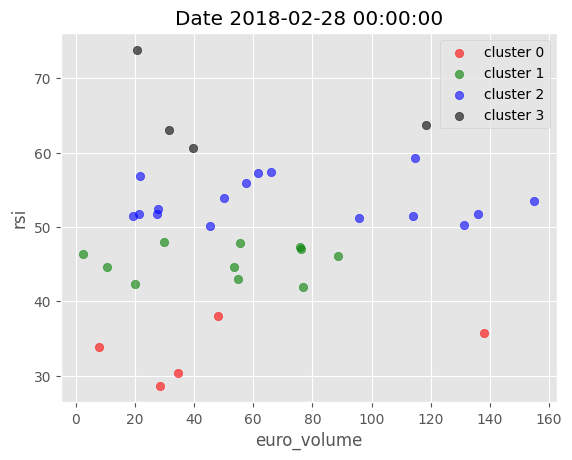

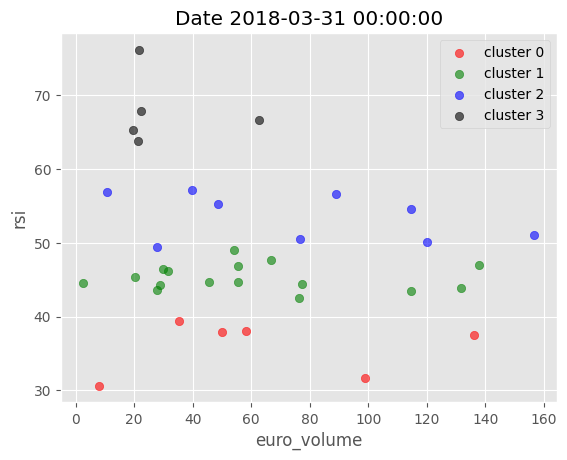

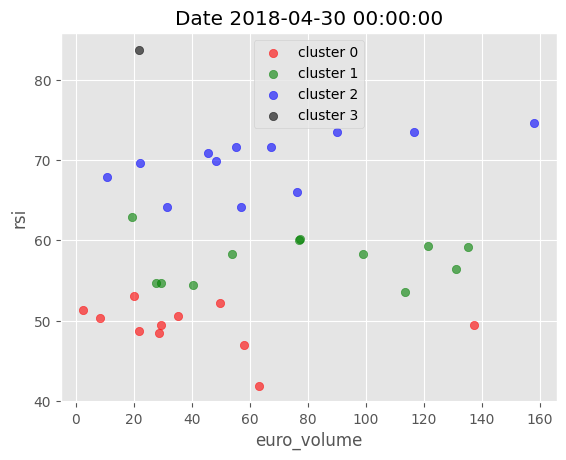

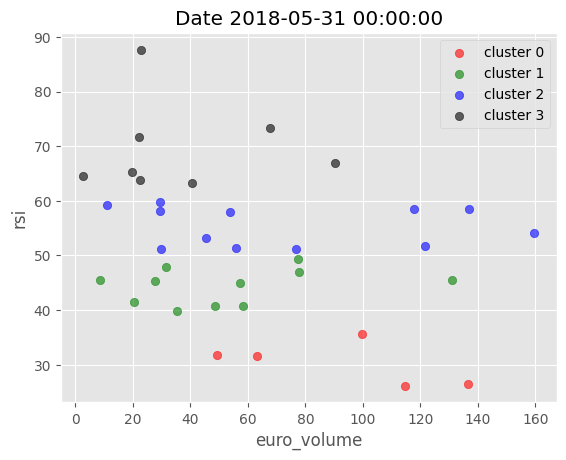

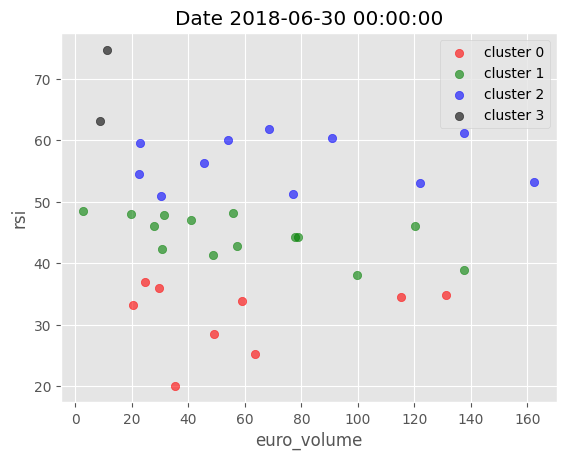

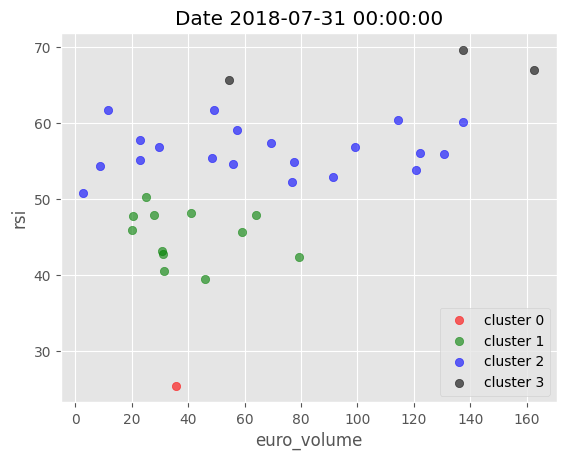

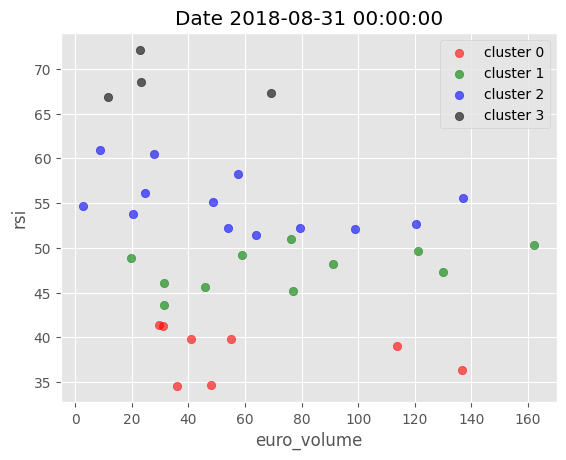

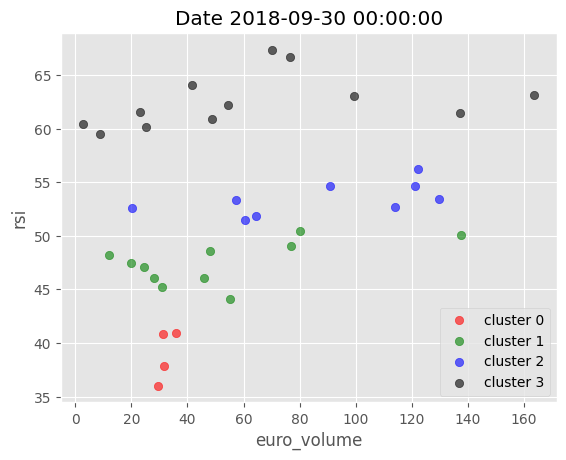

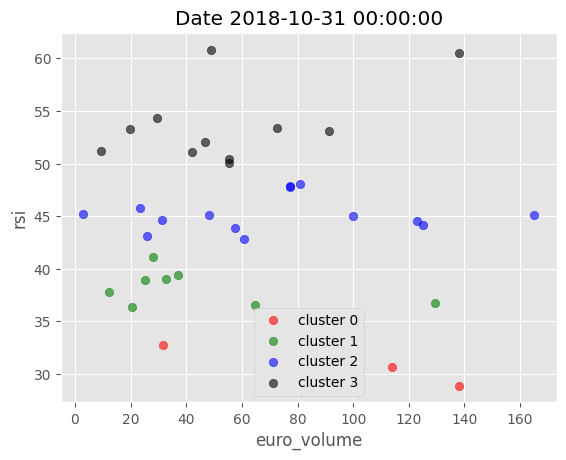

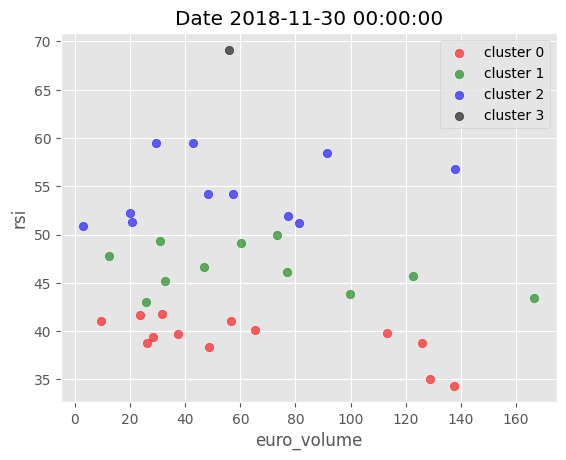

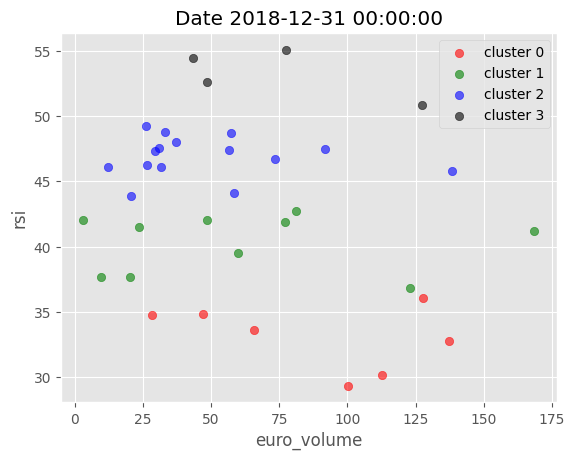

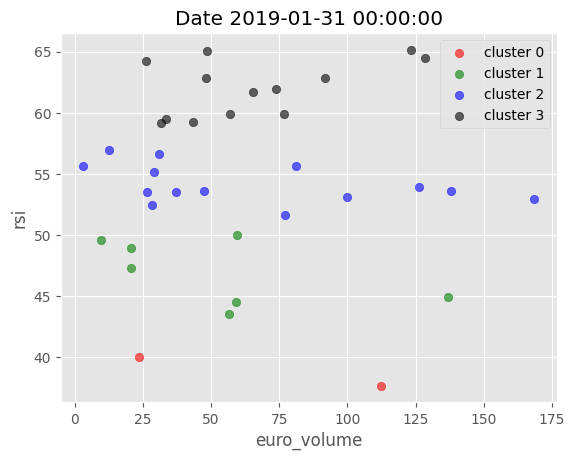

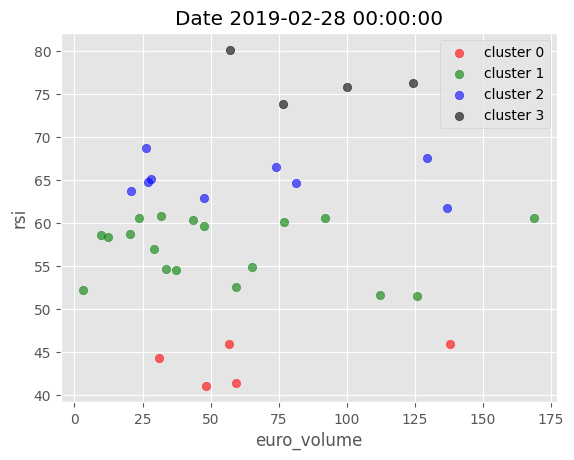

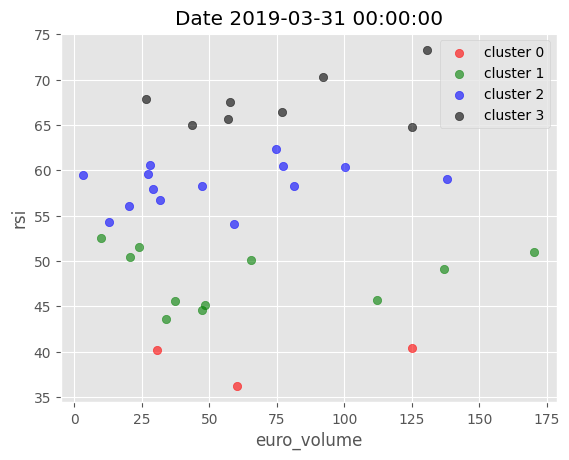

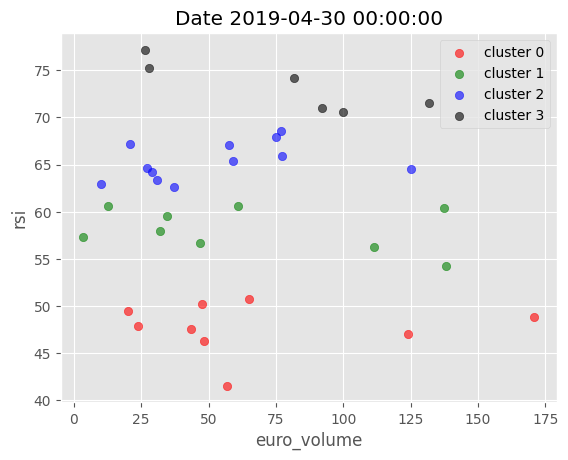

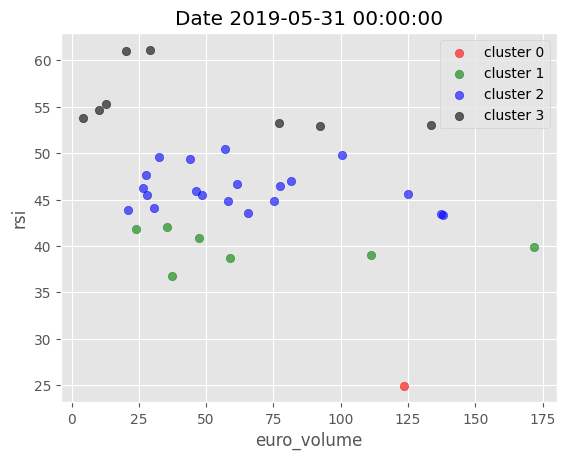

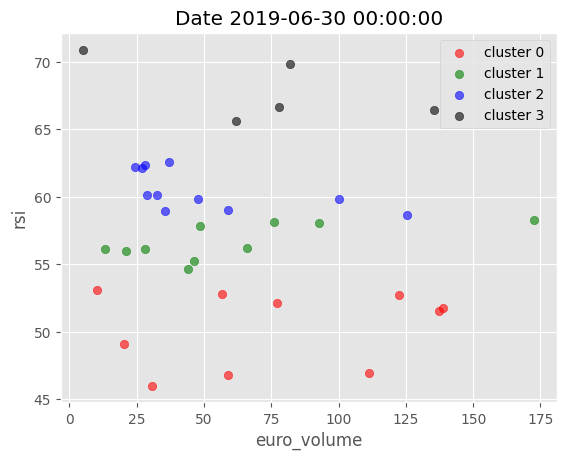

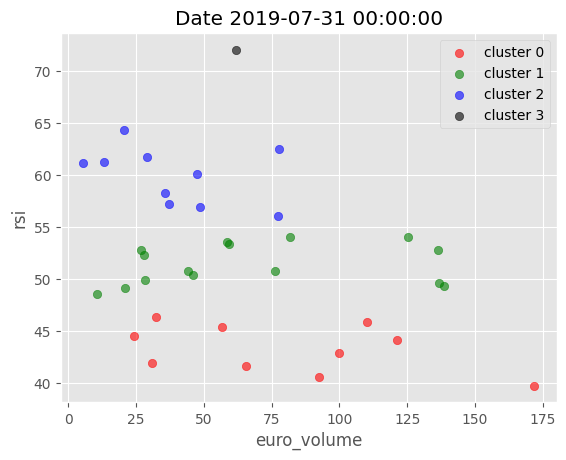

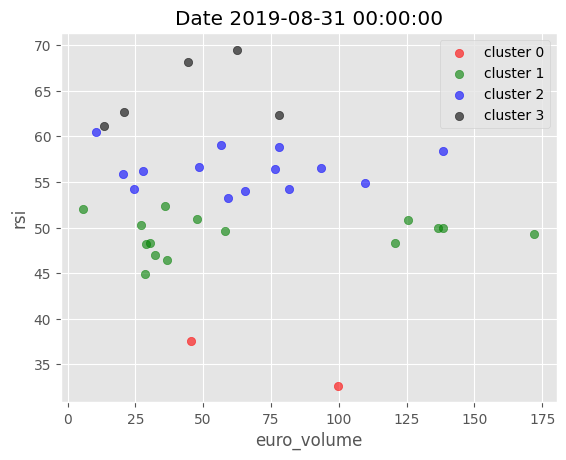

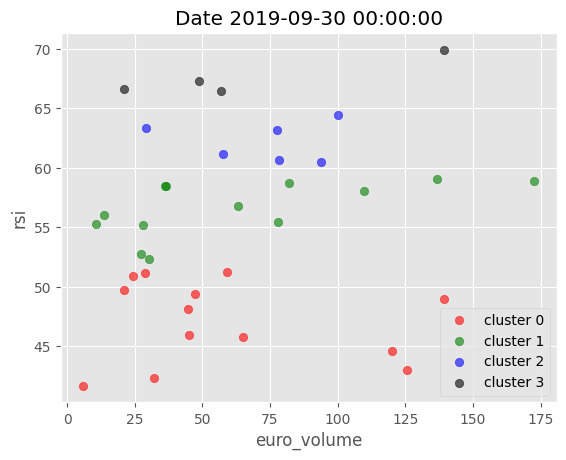

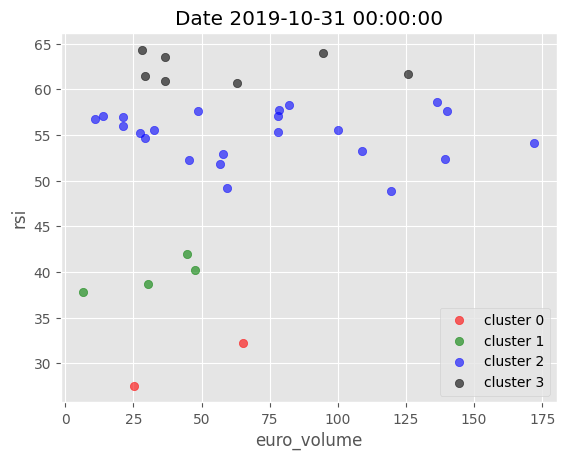

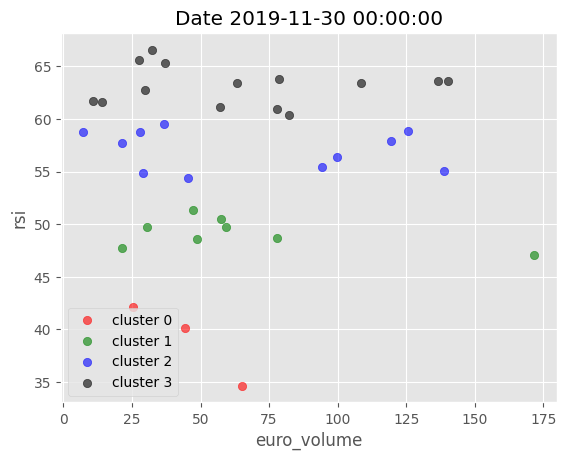

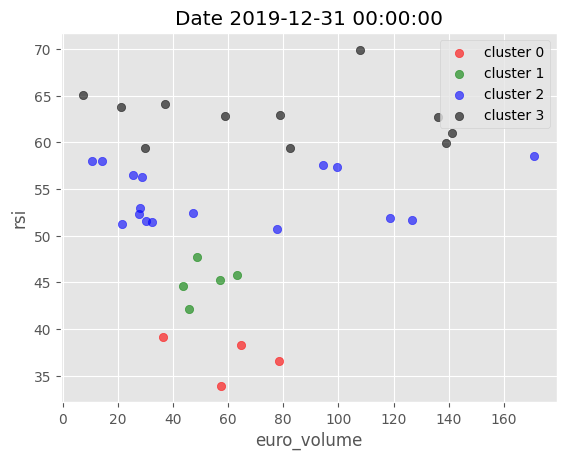

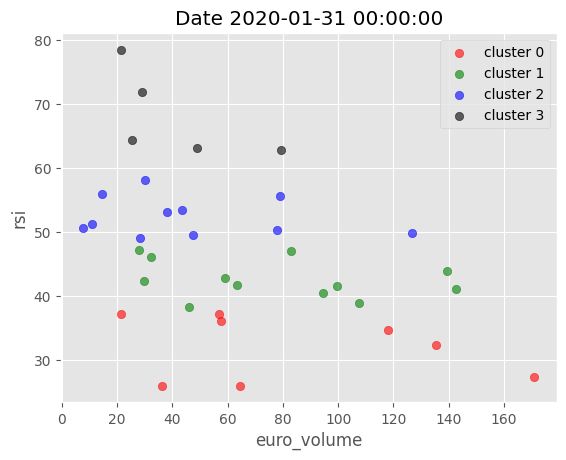

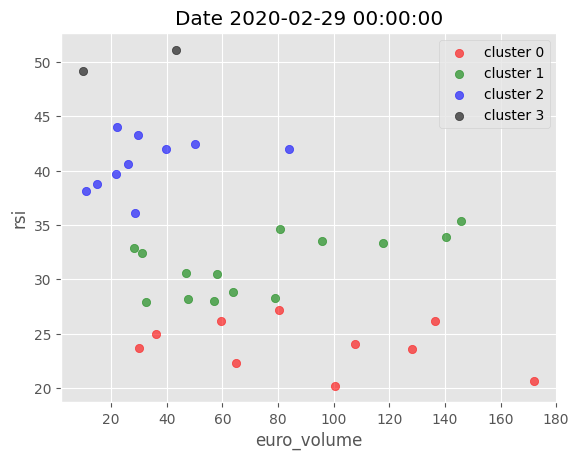

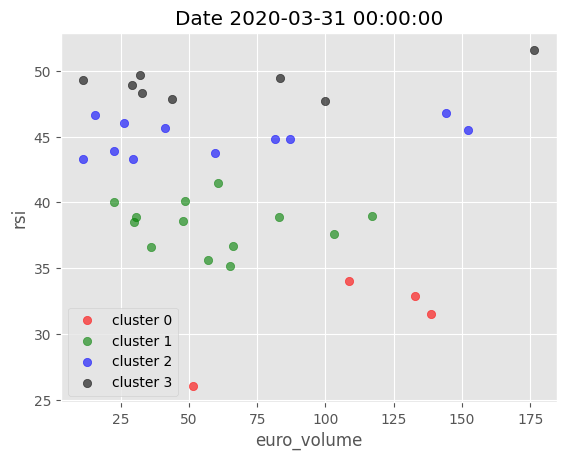

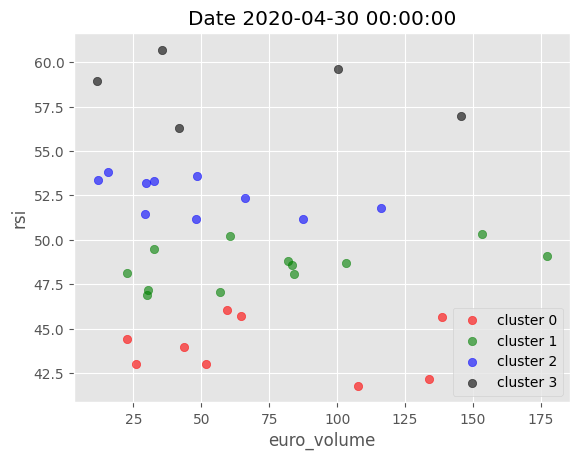

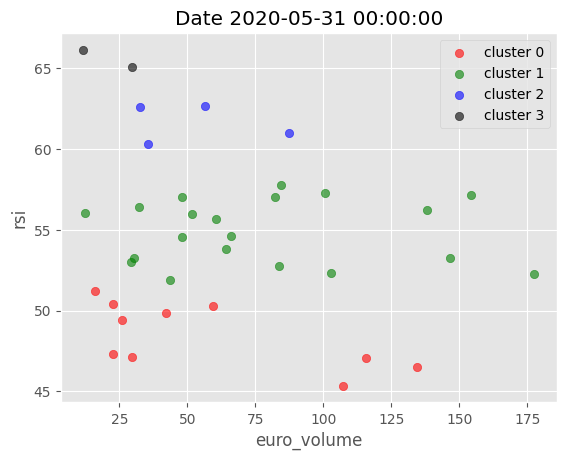

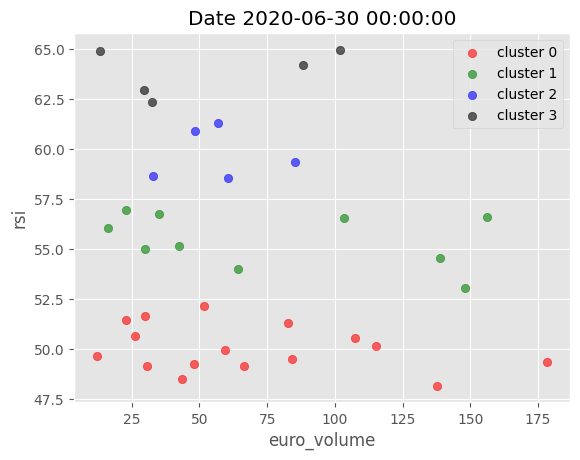

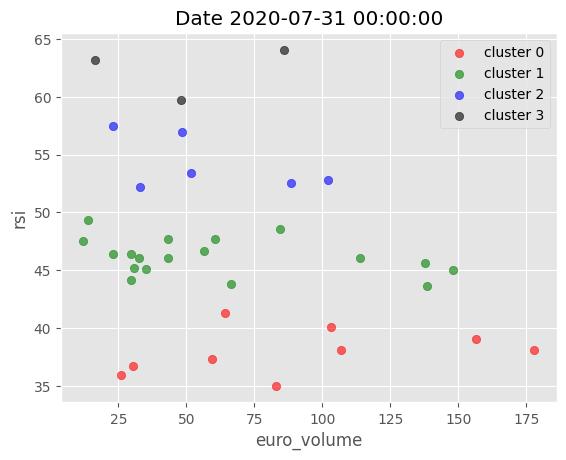

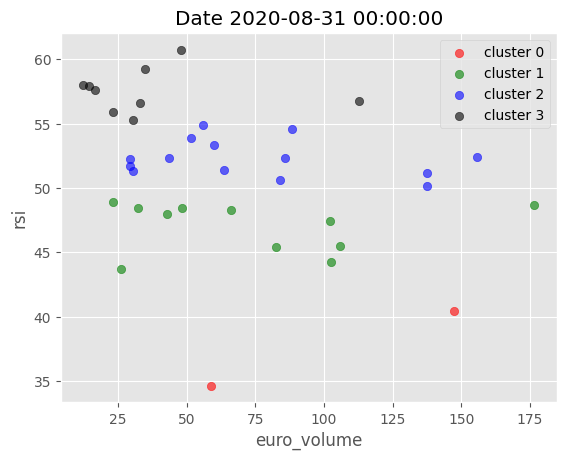

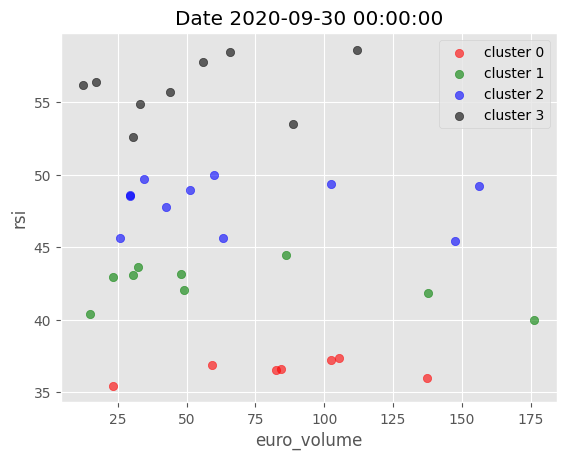

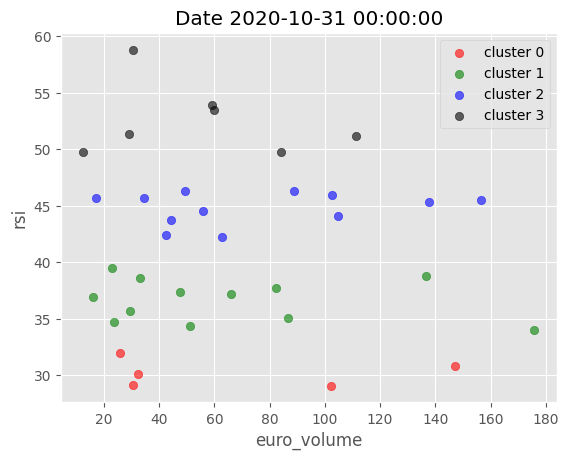

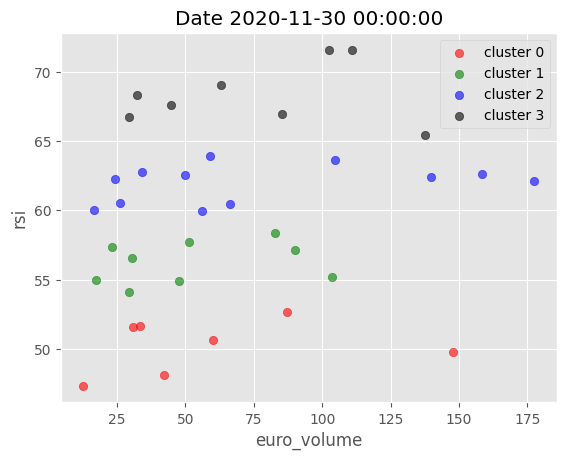

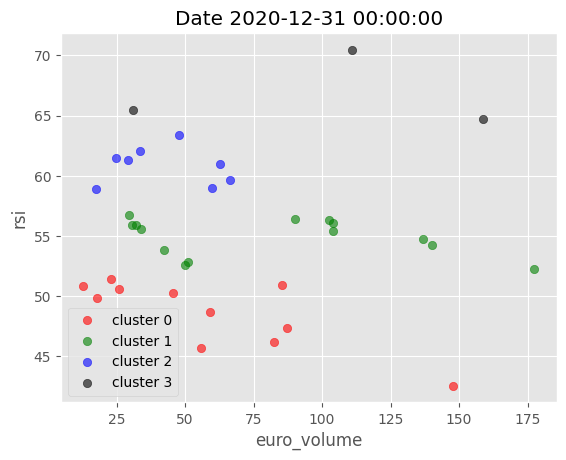

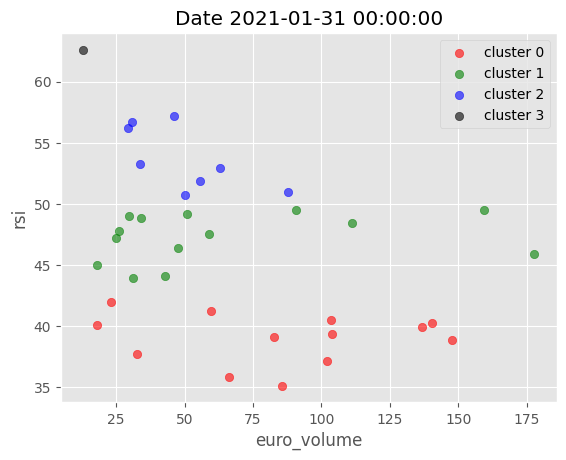

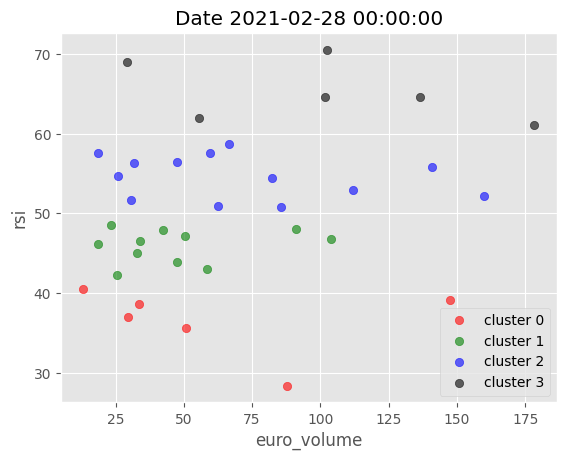

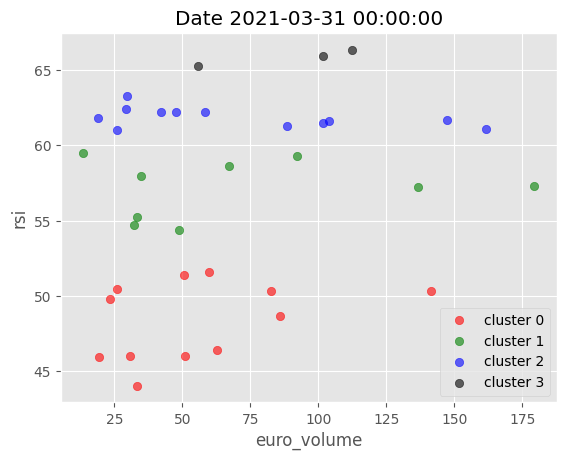

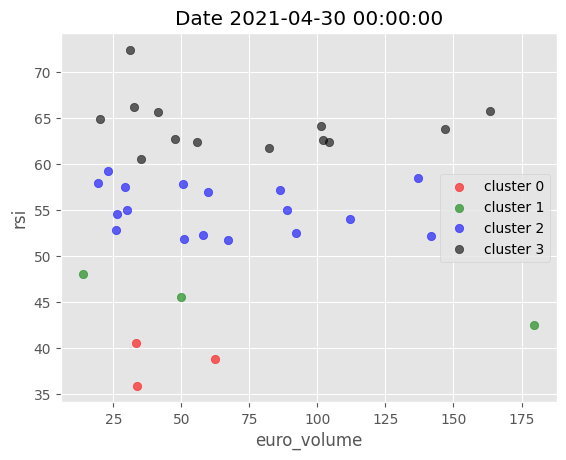

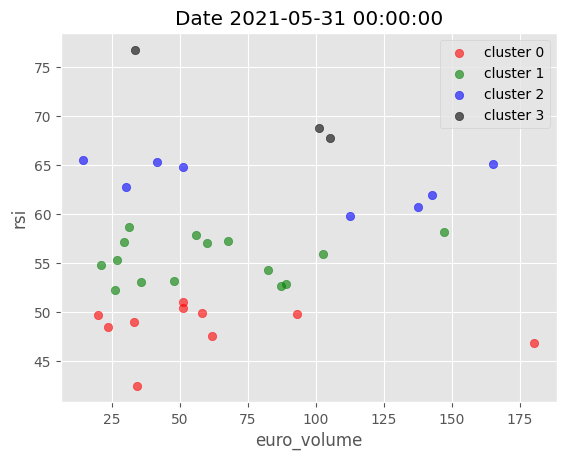

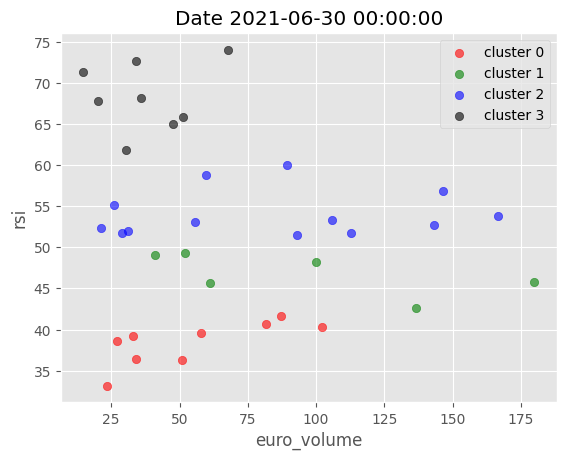

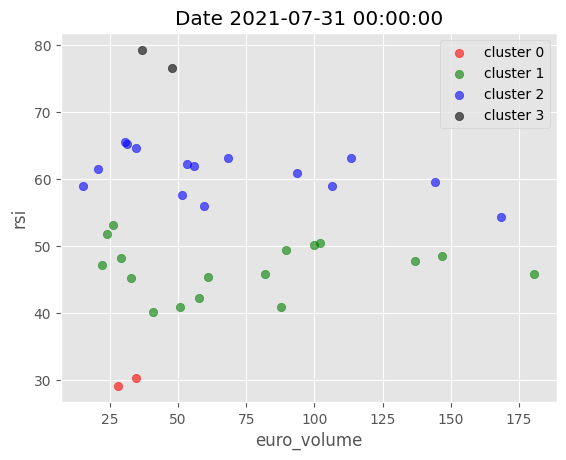

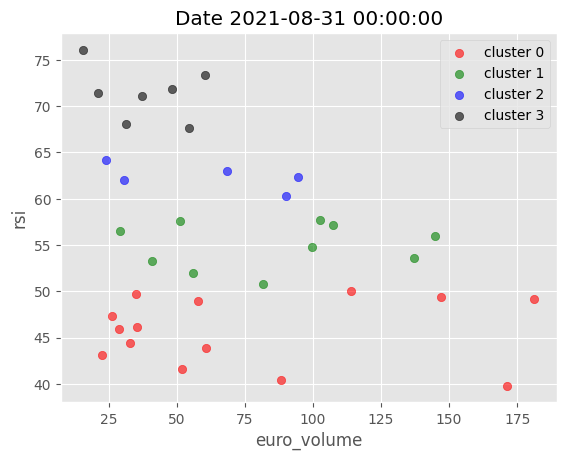

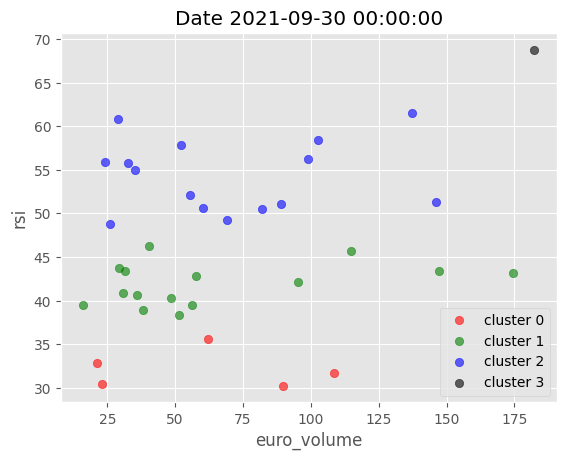

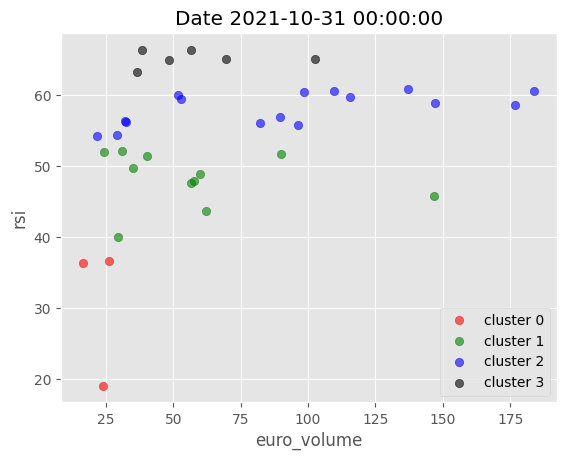

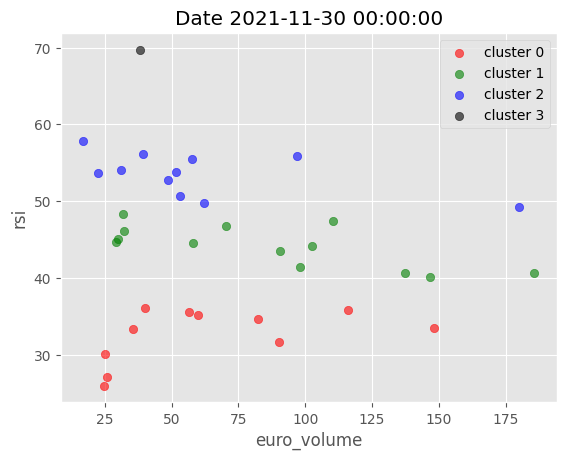

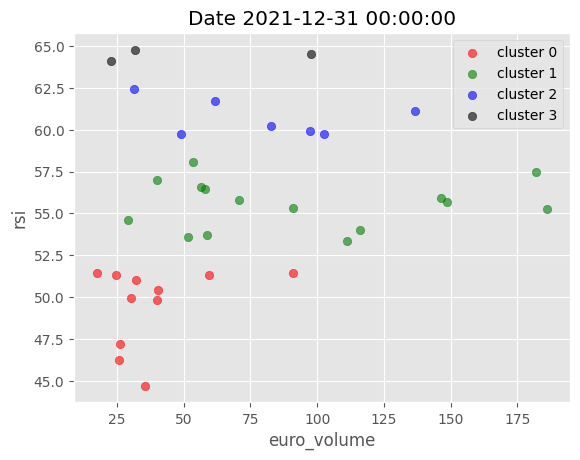

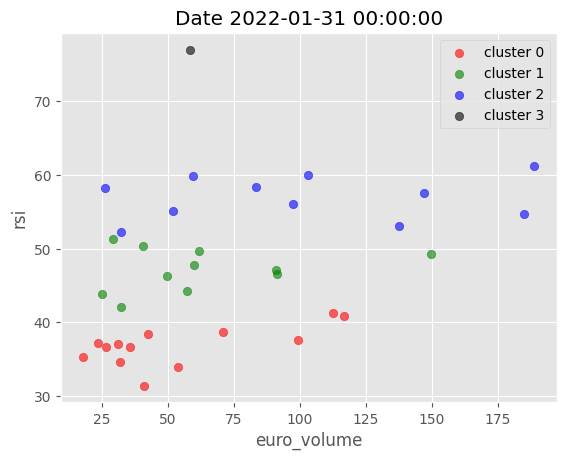

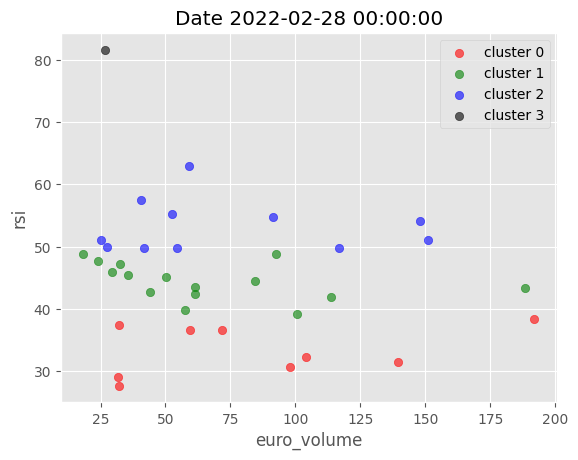

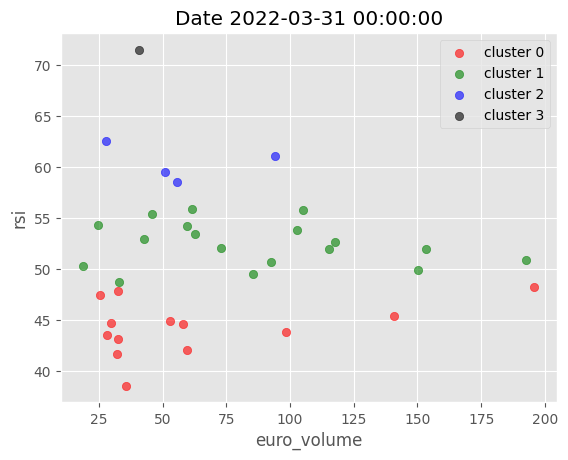

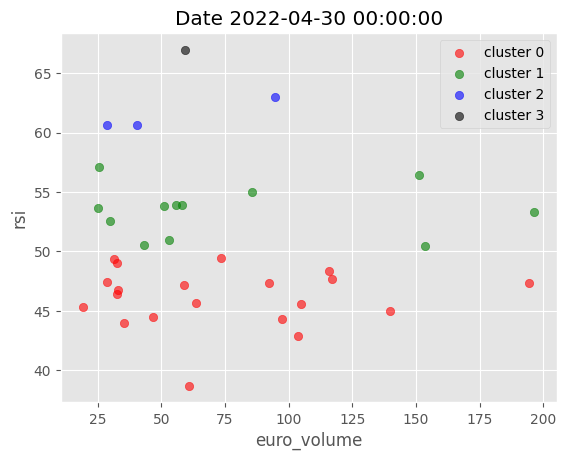

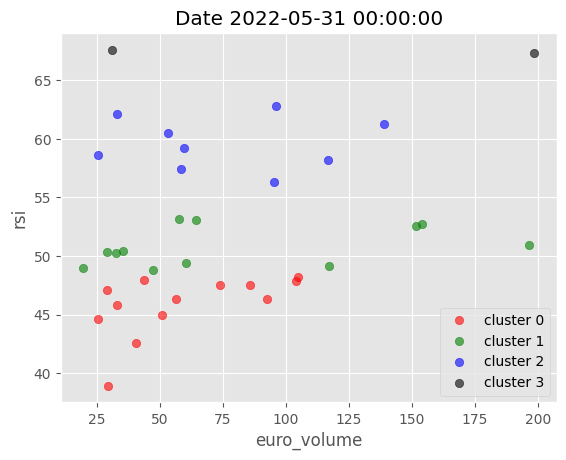

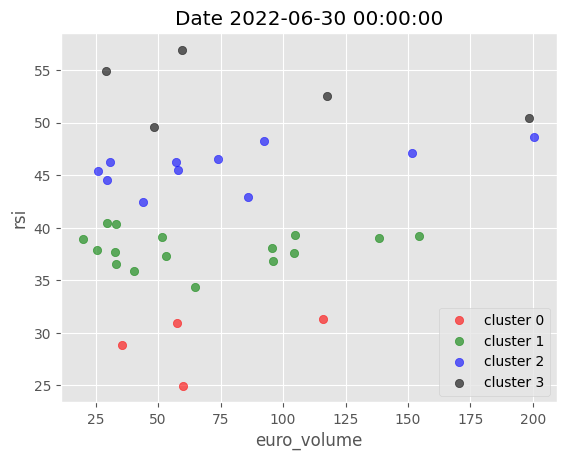

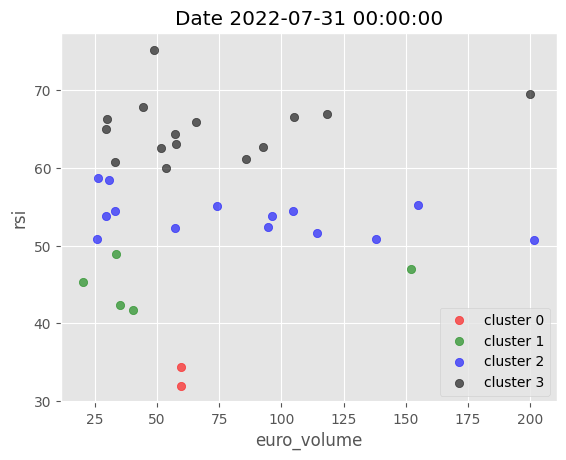

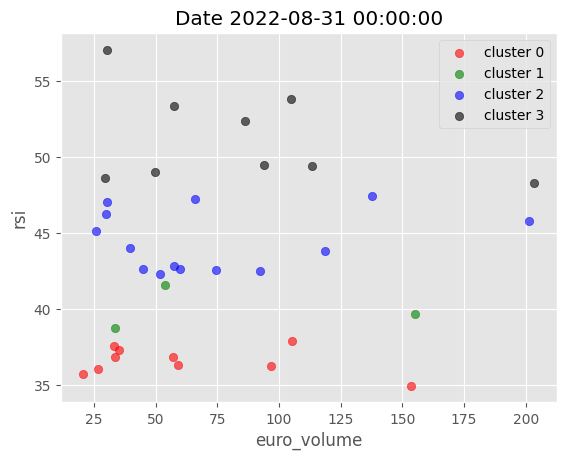

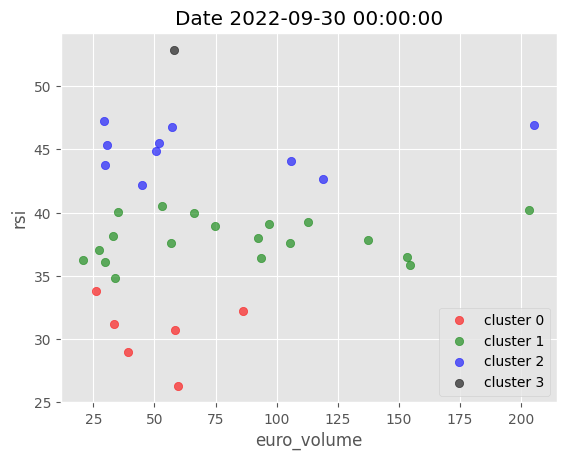

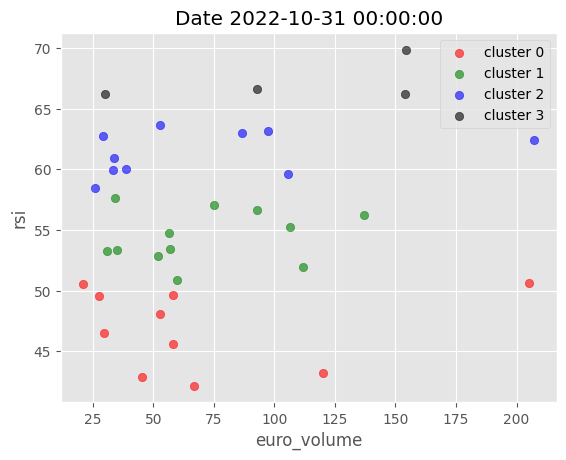

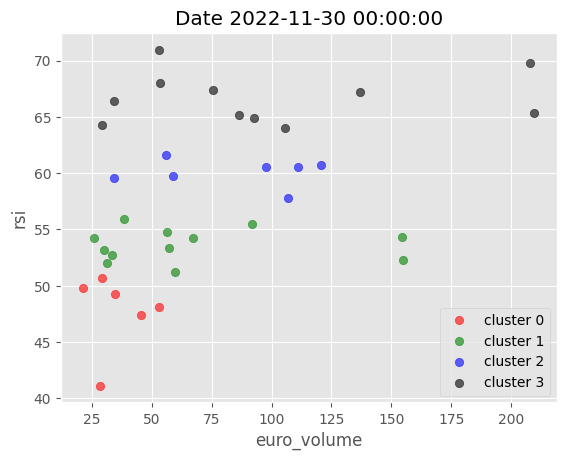

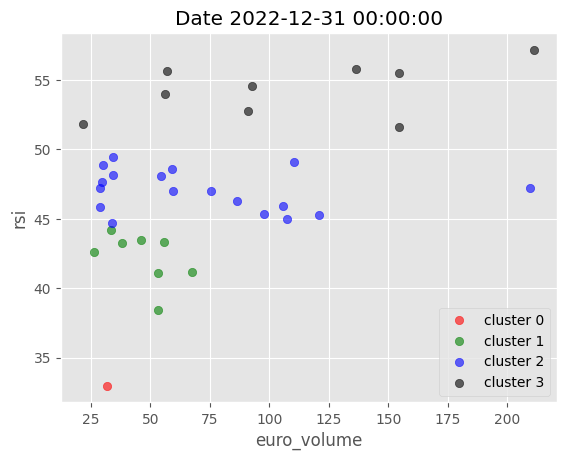

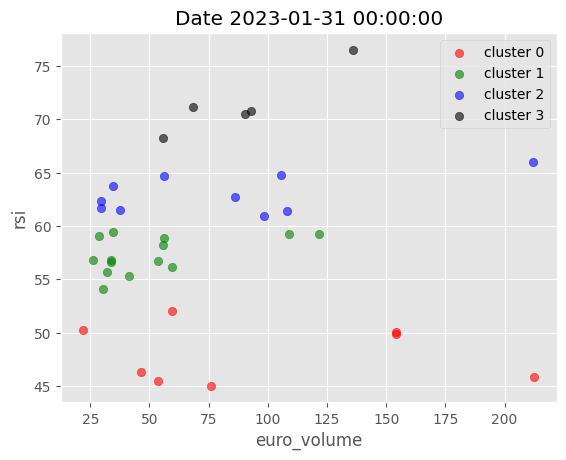

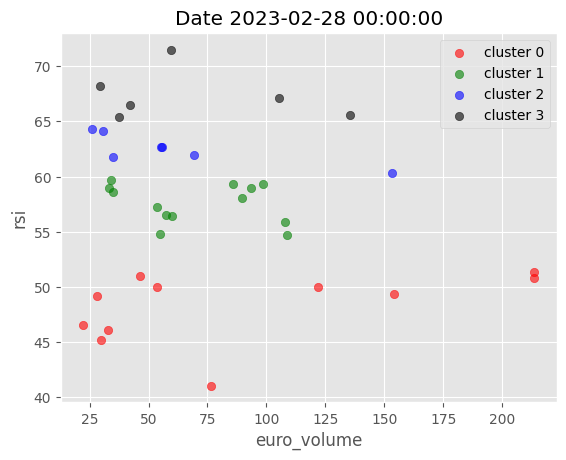

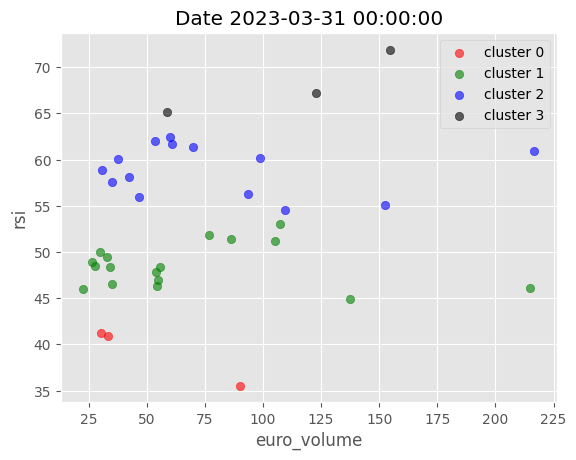

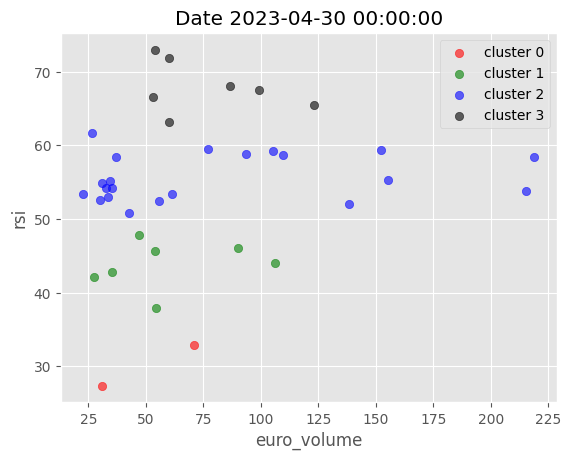

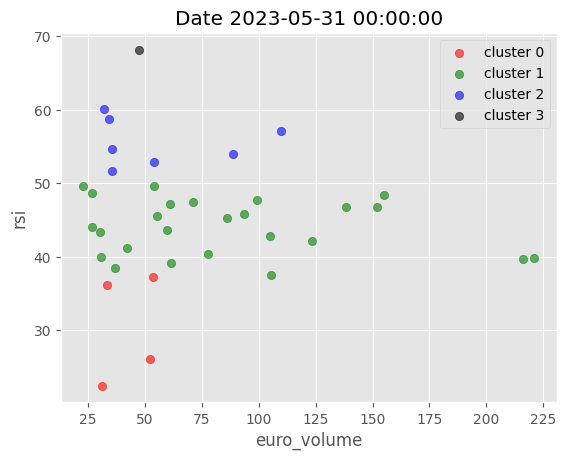

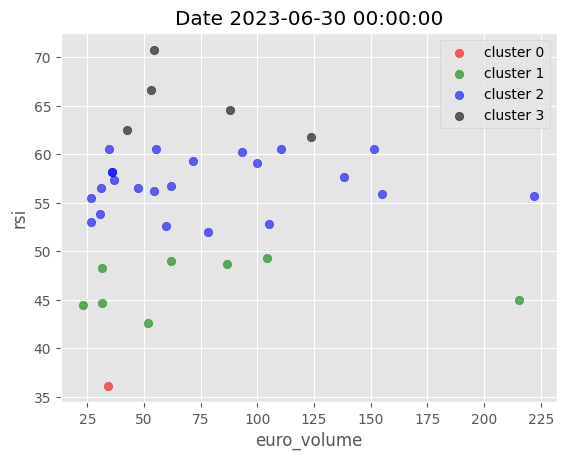

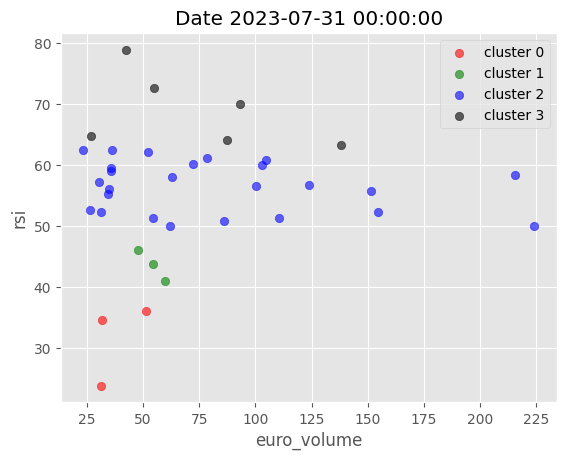

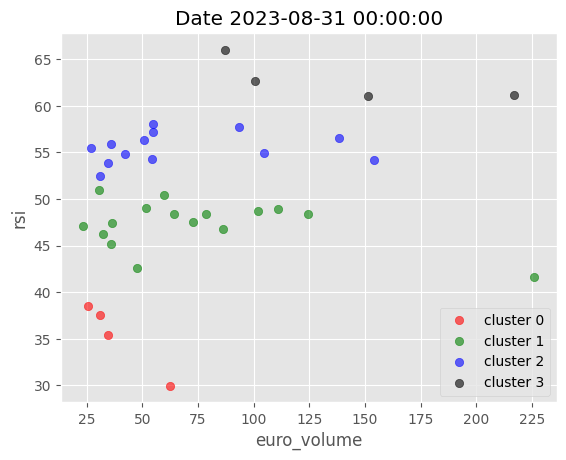

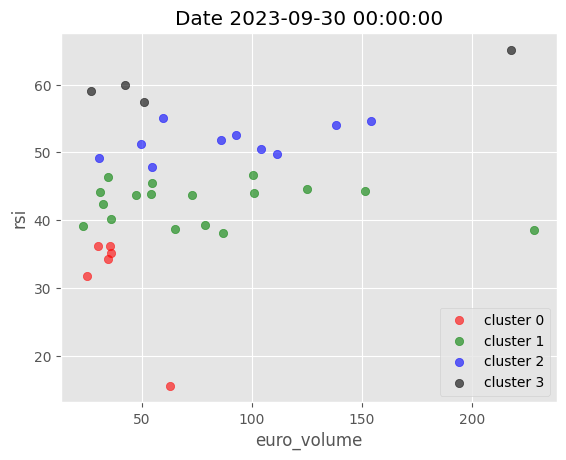

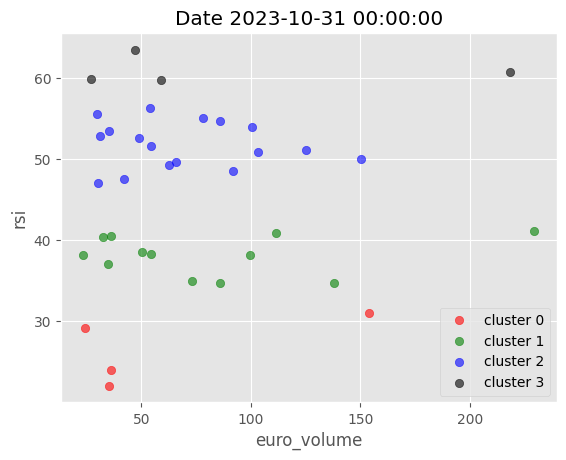

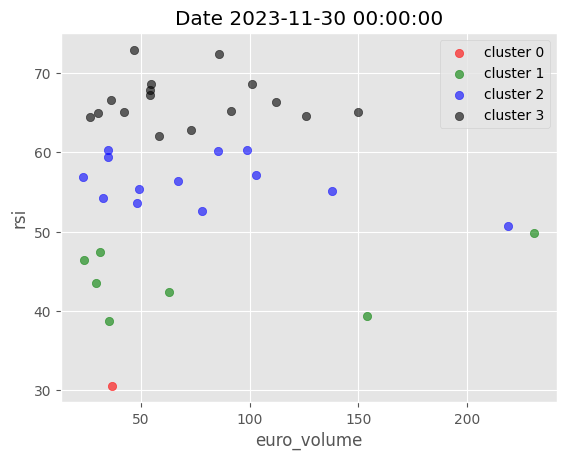

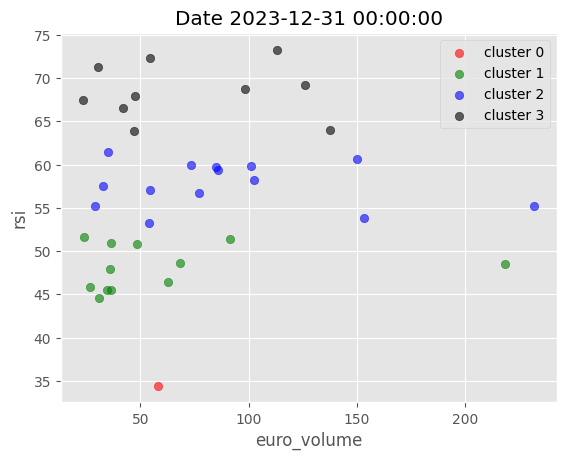

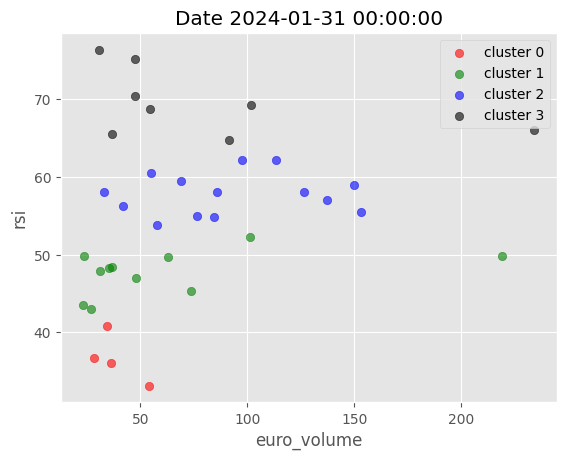

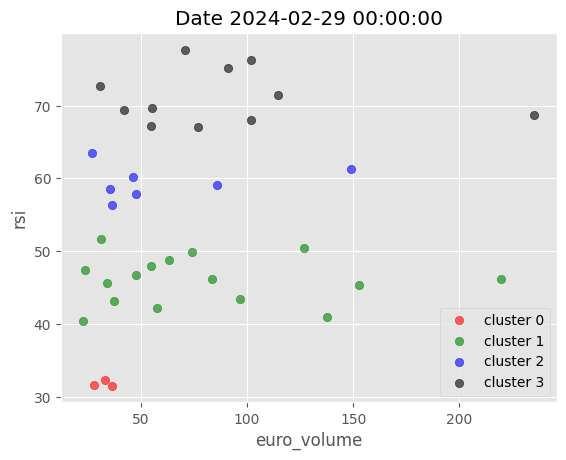

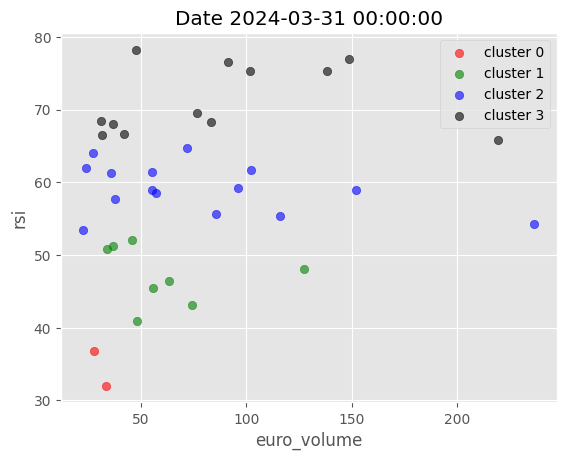

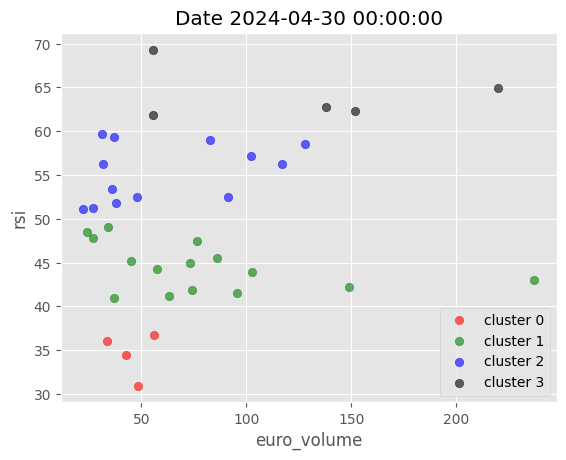

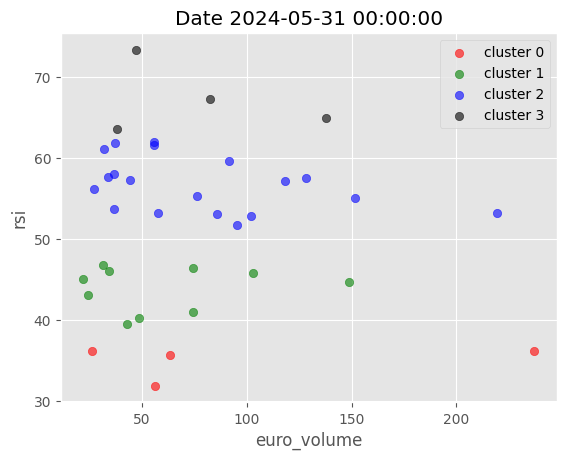

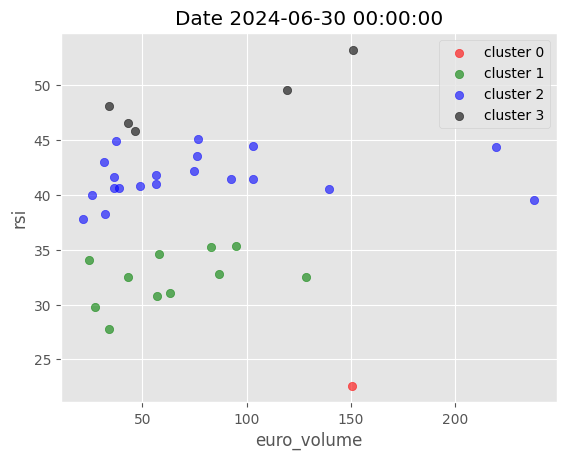

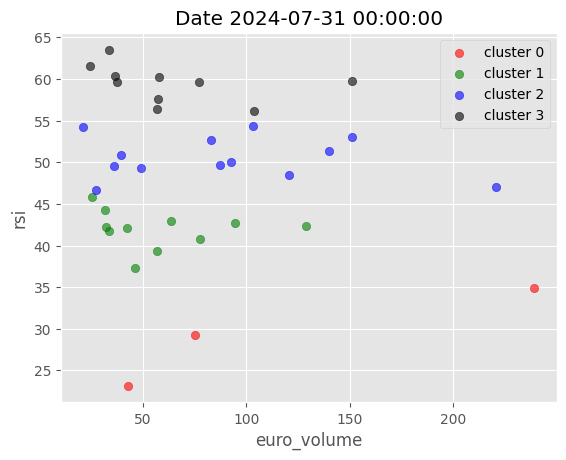

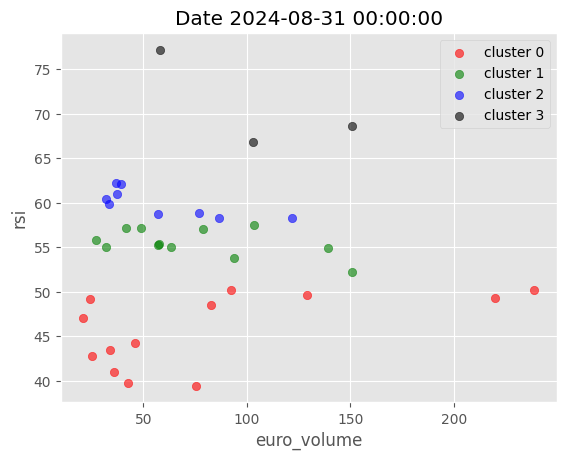

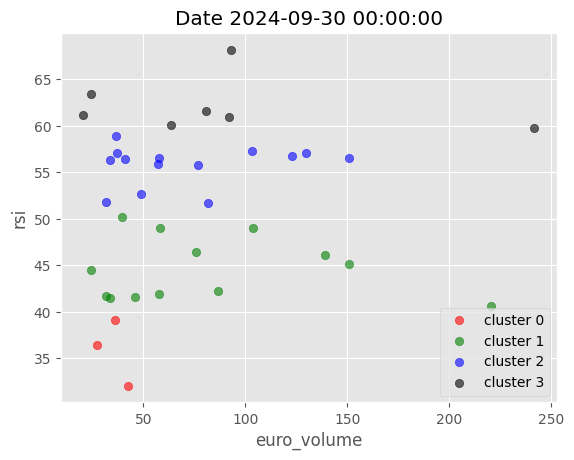

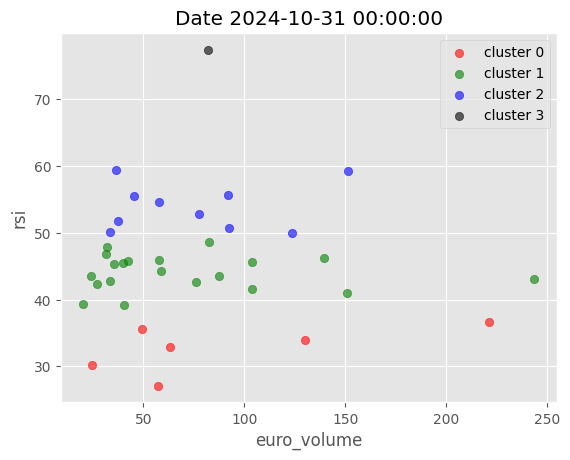

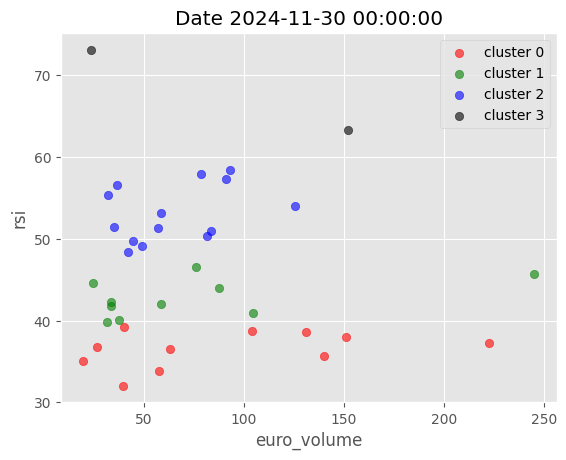

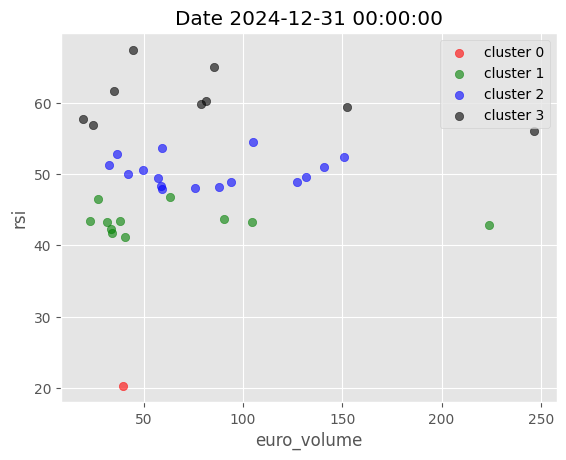

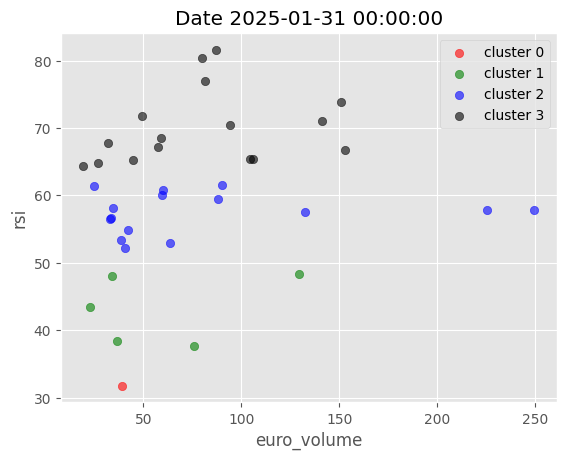

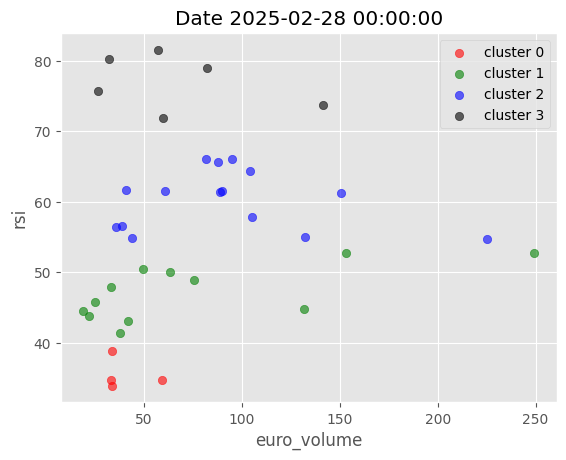

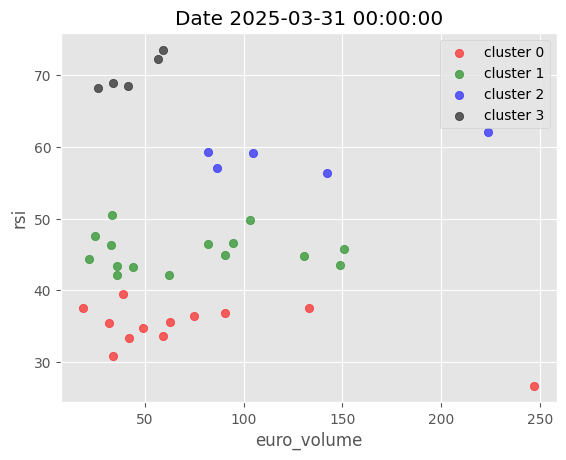

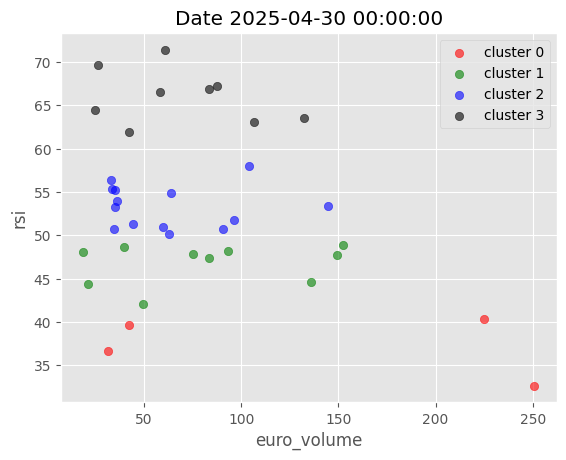

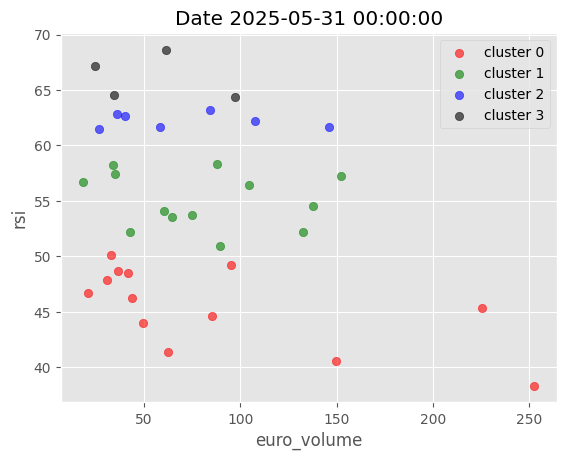

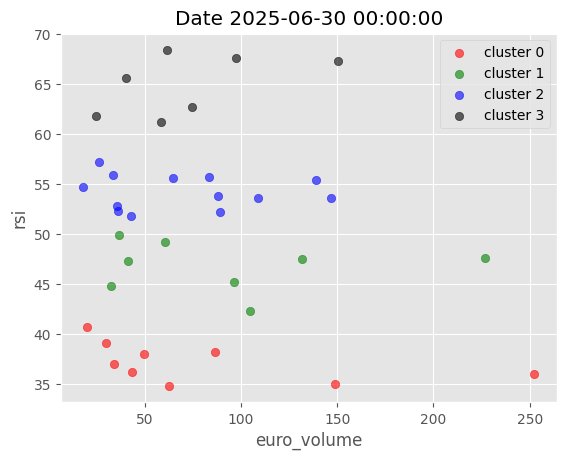

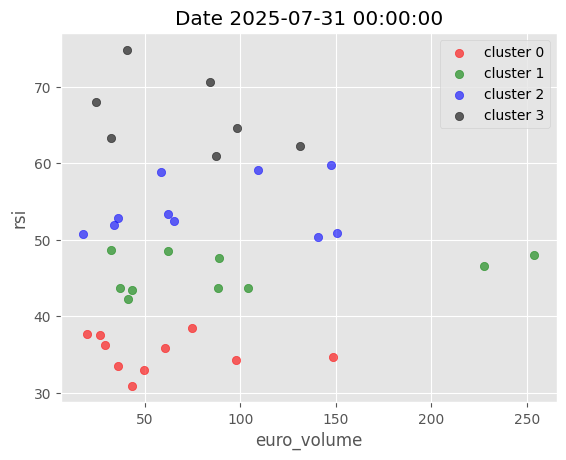

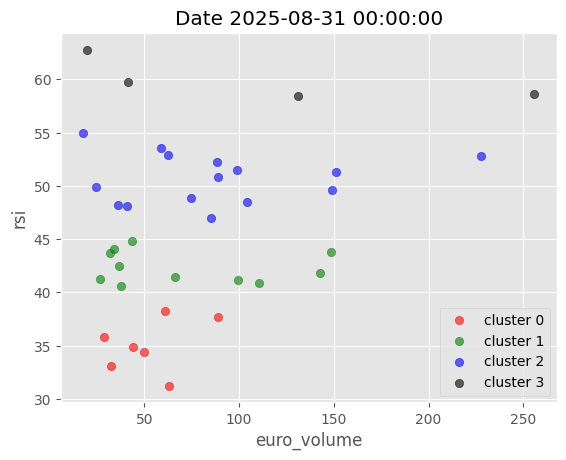

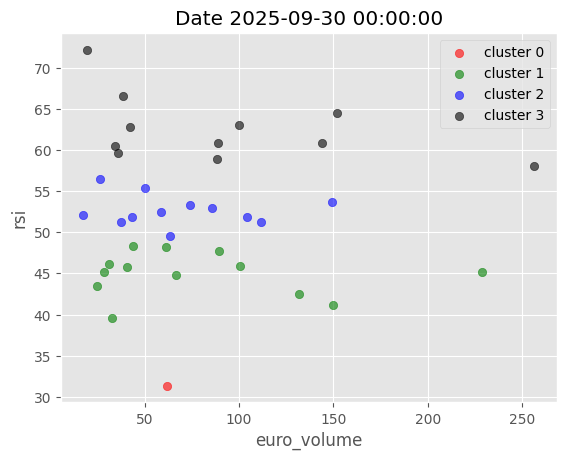

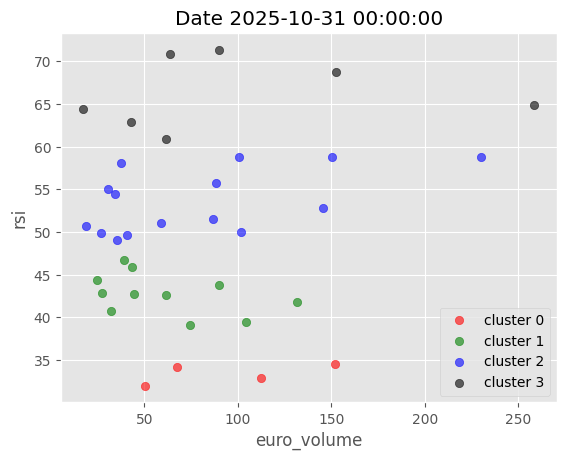

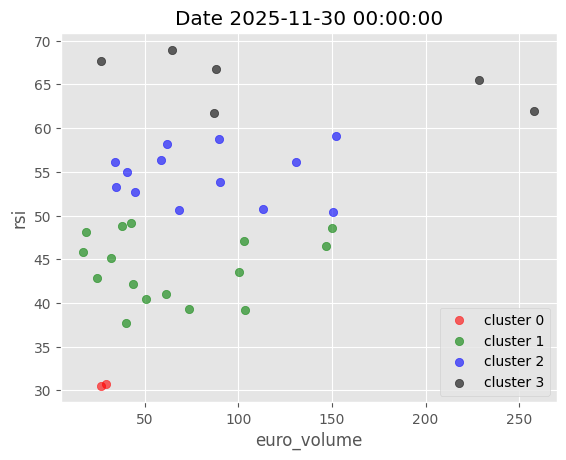

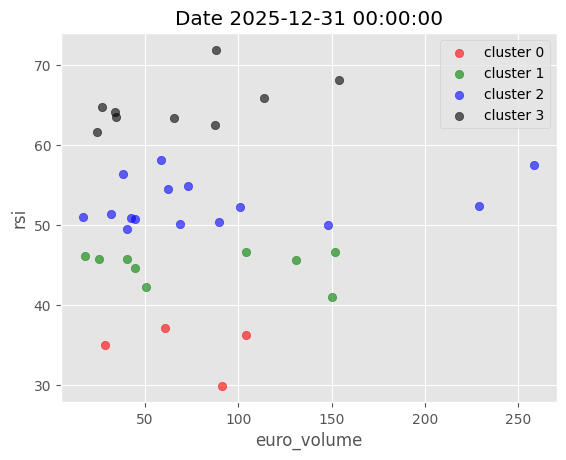

In [27]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_clusters(data):
    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]
    
    plt.scatter(cluster_0.iloc[:, 0], cluster_0.iloc[:, 2], color='red', label='cluster 0', alpha=0.6)
    plt.scatter(cluster_1.iloc[:, 0], cluster_1.iloc[:, 2], color='green', label='cluster 1', alpha=0.6)
    plt.scatter(cluster_2.iloc[:, 0], cluster_2.iloc[:, 2], color='blue', label='cluster 2', alpha=0.6)
    plt.scatter(cluster_3.iloc[:, 0], cluster_3.iloc[:, 2], color='black', label='cluster 3', alpha=0.6)
    
    plt.xlabel(data.columns[0])  # Nom de la colonne X
    plt.ylabel(data.columns[2])  # Nom de la colonne Y (RSI)
    plt.legend()
    plt.show()

# Plot pour chaque date
for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)


## Prediction using Supervised ML

NameError: name 'df' is not defined

🚀 XGBOOST - Prédiction Returns

📊 Préparation des données...
   Données complètes : 3,456 lignes
   Features          : 16
   Target            : return_1m

📈 Statistiques return_1m :
   Moyenne : 5.76%
   Médiane : 0.75%
   Std     : 302.93%
   Min     : -99.71%
   Max     : 17801.53%

🔀 Split Train/Test...
   Train : 2,764 observations
   Test  : 692 observations

🔧 Entraînement XGBoost...

✅ XGBoost entraîné
   Meilleure itération : 199

📊 Évaluation des performances...

Métrique            Train         Test
----------------------------------------
MSE              0.000494    45.642135
RMSE             0.022222     6.755896
MAE              0.017126     0.294541
R²                 0.9368       0.0021

💡 Interprétation :
   ❌ R² Test = 0.0021 → Très faible pouvoir prédictif

📈 Feature Importance...

Top 10 features :
   rsi                  : 0.3205
   macd                 : 0.2552
   return_2m            : 0.0869
   Mkt-RF               : 0.0431
   return_3m            : 0.0354
  

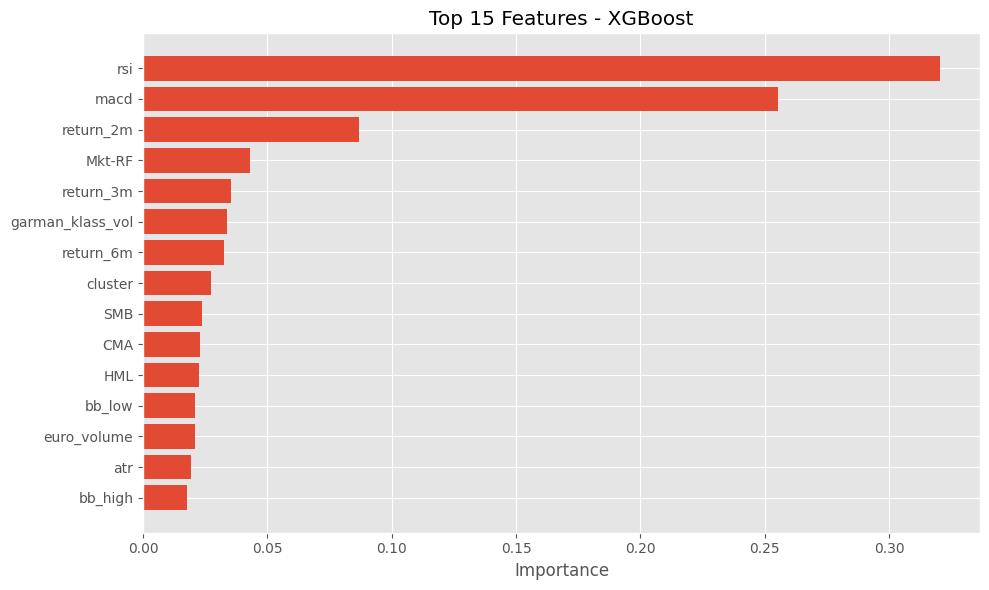


💾 Génération des prédictions...



📊 Statistiques prédictions :
   Nombre  : 3,456
   Moyenne : 0.75%
   Médiane : 0.99%
   Std     : 8.20%
   Min     : -52.06%
   Max     : 52.73%

📈 Distribution prédictions :
   Négatives (< 0%)   : 1,529 (44.2%)
   Faibles (0-1%)     : 200 (5.8%)
   Moyennes (1-2%)    : 170 (4.9%)
   Fortes (> 2%)      : 1,557 (45.1%)

🎯 Analyse par Cluster...

Prédictions moyennes par cluster :
         predicted_return_xgb_count  predicted_return_xgb_mean  \
cluster                                                          
0                               614                    -0.0726   
1                              1117                    -0.0186   
2                              1165                     0.0336   
3                               560                     0.0928   

         predicted_return_xgb_std  return_1m_mean  
cluster                                            
0                          0.0766         -0.0729  
1                          0.0617         -0.0174  
2          

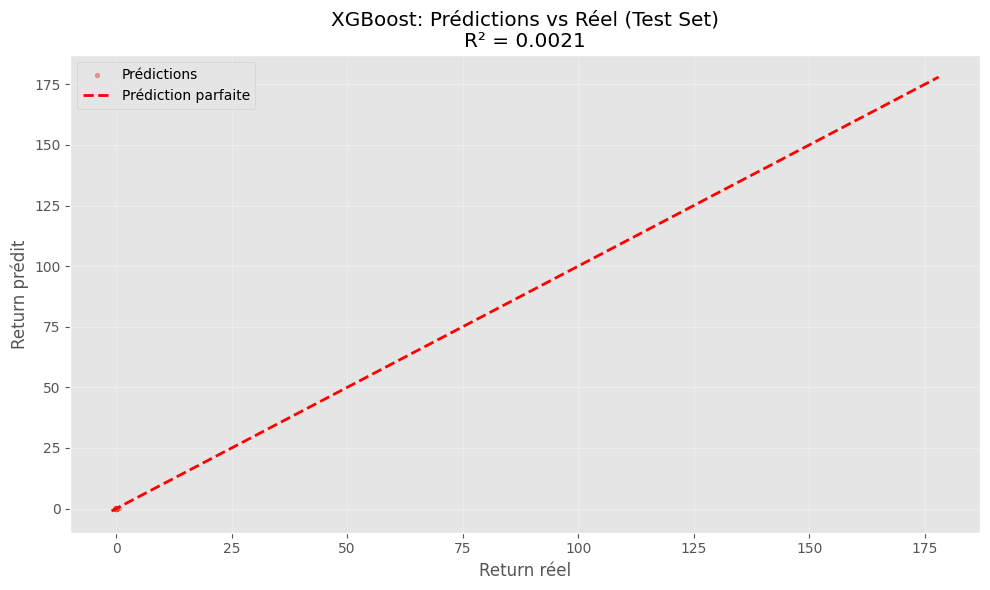


✅ XGBOOST TERMINÉ

Variables disponibles :
   - xgb_model          : Modèle entraîné
   - ml_data            : Données avec 'predicted_return_xgb'
   - feature_importance : Importance des features

Prochaine étape : Filtrage pour optimisation portefeuille


In [28]:
"""
=============================================================================
XGBOOST - Prédiction Returns Actions (Cluster 3)
=============================================================================

Objectif :
    - Filtrer actions Cluster 3 (momentum RSI ~70)
    - Prédire return_1m (regression)
    - Utiliser pour optimisation portefeuille
    
Données :
    - Input  : data (DataFrame avec MultiIndex date/ticker)
    - Output : Modèle XGBoost entraîné
"""

import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("🚀 XGBOOST - Prédiction Returns")
print("="*70)


# =============================================================================
# 1. PRÉPARATION DES DONNÉES
# =============================================================================

print("\n📊 Préparation des données...")

# Features pour XGBoost
feature_cols = [
    # Indicateurs techniques
    'rsi', 'macd', 'bb_low', 'bb_high', 'atr',
    
    # Volume
    'euro_volume', 'garman_klass_vol',
    
    # Returns passés
    'return_2m', 'return_3m', 'return_6m',
    
    # Fama-French 5 facteurs
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA',
    
    # Cluster (important!)
    'cluster'
]

# Target : Return 1 mois suivant
target_col = 'return_1m'

# Supprimer NaN
ml_data = data[feature_cols + [target_col]].dropna().copy()

print(f"   Données complètes : {ml_data.shape[0]:,} lignes")
print(f"   Features          : {len(feature_cols)}")
print(f"   Target            : {target_col}")

# Statistiques target
print(f"\n📈 Statistiques {target_col} :")
print(f"   Moyenne : {ml_data[target_col].mean()*100:.2f}%")
print(f"   Médiane : {ml_data[target_col].median()*100:.2f}%")
print(f"   Std     : {ml_data[target_col].std()*100:.2f}%")
print(f"   Min     : {ml_data[target_col].min()*100:.2f}%")
print(f"   Max     : {ml_data[target_col].max()*100:.2f}%")


# =============================================================================
# 2. TRAIN/TEST SPLIT (80/20)
# =============================================================================

print("\n🔀 Split Train/Test...")

X = ml_data[feature_cols]
y = ml_data[target_col]

# Split temporel (pas shuffle pour time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=0, 
    shuffle=False  # Important pour time series
)

print(f"   Train : {X_train.shape[0]:,} observations")
print(f"   Test  : {X_test.shape[0]:,} observations")


# =============================================================================
# 3. MODÈLE XGBOOST
# =============================================================================

print("\n🔧 Entraînement XGBoost...\n")

# Hyperparamètres
xgb_model = XGBRegressor(
    n_estimators=200,          # Nombre d'arbres
    max_depth=5,               # Profondeur max
    learning_rate=0.05,        # Taux d'apprentissage
    subsample=0.8,             # % données par arbre
    colsample_bytree=0.8,      # % features par arbre
    random_state=0,
    n_jobs=-1,                 # Tous les cores CPU
    enable_categorical=True,   # Pour gérer 'cluster' comme catégorie
    early_stopping_rounds=20,  # Early stopping
    eval_metric='rmse'         # Métrique pour early stopping
)

# Entraînement
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print(f"✅ XGBoost entraîné")
print(f"   Meilleure itération : {xgb_model.best_iteration}")


# =============================================================================
# 4. ÉVALUATION
# =============================================================================

print("\n📊 Évaluation des performances...\n")

# Prédictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Métriques Train
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Métriques Test
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

# Affichage
print(f"{'Métrique':<12} {'Train':>12} {'Test':>12}")
print(f"{'-'*40}")
print(f"{'MSE':<12} {mse_train:>12.6f} {mse_test:>12.6f}")
print(f"{'RMSE':<12} {np.sqrt(mse_train):>12.6f} {np.sqrt(mse_test):>12.6f}")
print(f"{'MAE':<12} {mae_train:>12.6f} {mae_test:>12.6f}")
print(f"{'R²':<12} {r2_train:>12.4f} {r2_test:>12.4f}")

# Interprétation R²
print(f"\n💡 Interprétation :")
if r2_test > 0.05:
    print(f"   ✅ R² Test = {r2_test:.4f} → Le modèle capture {r2_test*100:.2f}% de la variance")
elif r2_test > 0.01:
    print(f"   ⚠️ R² Test = {r2_test:.4f} → Capture faible ({r2_test*100:.2f}%)")
else:
    print(f"   ❌ R² Test = {r2_test:.4f} → Très faible pouvoir prédictif")


# =============================================================================
# 5. FEATURE IMPORTANCE
# =============================================================================

print("\n📈 Feature Importance...\n")

# Créer DataFrame
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 10
print("Top 10 features :")
for i, row in feature_importance.head(10).iterrows():
    print(f"   {row['feature']:<20} : {row['importance']:.4f}")

# Graphique
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(15), 
         feature_importance['importance'].head(15))
plt.xlabel('Importance')
plt.title('Top 15 Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# =============================================================================
# 6. PRÉDICTIONS SUR ml_data (pour analyse)
# =============================================================================

print("\n💾 Génération des prédictions...\n")

# Prédire sur ml_data (données nettoyées)
ml_data['predicted_return_xgb'] = xgb_model.predict(ml_data[feature_cols])

# Statistiques prédictions
preds = ml_data['predicted_return_xgb']
print(f"📊 Statistiques prédictions :")
print(f"   Nombre  : {len(preds):,}")
print(f"   Moyenne : {preds.mean()*100:.2f}%")
print(f"   Médiane : {preds.median()*100:.2f}%")
print(f"   Std     : {preds.std()*100:.2f}%")
print(f"   Min     : {preds.min()*100:.2f}%")
print(f"   Max     : {preds.max()*100:.2f}%")

# Distribution
print(f"\n📈 Distribution prédictions :")
print(f"   Négatives (< 0%)   : {(preds < 0).sum():,} ({(preds < 0).mean()*100:.1f}%)")
print(f"   Faibles (0-1%)     : {((preds >= 0) & (preds < 0.01)).sum():,} ({((preds >= 0) & (preds < 0.01)).mean()*100:.1f}%)")
print(f"   Moyennes (1-2%)    : {((preds >= 0.01) & (preds < 0.02)).sum():,} ({((preds >= 0.01) & (preds < 0.02)).mean()*100:.1f}%)")
print(f"   Fortes (> 2%)      : {(preds >= 0.02).sum():,} ({(preds >= 0.02).mean()*100:.1f}%)")


# =============================================================================
# 7. ANALYSE PAR CLUSTER
# =============================================================================

print("\n🎯 Analyse par Cluster...\n")

# Grouper par cluster
cluster_analysis = ml_data.groupby('cluster').agg({
    'predicted_return_xgb': ['count', 'mean', 'std'],
    target_col: 'mean'
}).round(4)

cluster_analysis.columns = ['_'.join(col).strip() for col in cluster_analysis.columns]

print("Prédictions moyennes par cluster :")
print(cluster_analysis)

# Focus sur Cluster 3 (momentum)
if 3 in ml_data['cluster'].unique():
    cluster3 = ml_data[ml_data['cluster'] == 3]
    cluster3_pred = cluster3['predicted_return_xgb']
    
    print(f"\n💡 Cluster 3 (Momentum) :")
    print(f"   Observations        : {len(cluster3_pred):,}")
    print(f"   Return prédit moyen : {cluster3_pred.mean()*100:.2f}%")
    print(f"   Return réel moyen   : {cluster3[target_col].mean()*100:.2f}%")
    print(f"   Prédictions > 0%    : {(cluster3_pred > 0).sum():,} ({(cluster3_pred > 0).mean()*100:.1f}%)")
    print(f"   Prédictions > 1%    : {(cluster3_pred > 0.01).sum():,} ({(cluster3_pred > 0.01).mean()*100:.1f}%)")
    print(f"   Prédictions > 2%    : {(cluster3_pred > 0.02).sum():,} ({(cluster3_pred > 0.02).mean()*100:.1f}%)")


# =============================================================================
# 8. GRAPHIQUE : PRÉDICTIONS VS RÉEL
# =============================================================================

print("\n📊 Génération graphique Pred vs Réel...")

plt.figure(figsize=(10, 6))

# Scatter plot (échantillon 10% pour lisibilité)
sample_size = int(0.1 * len(y_test))
sample_idx = np.random.choice(len(y_test), sample_size, replace=False)

plt.scatter(
    y_test.iloc[sample_idx], 
    y_pred_test[sample_idx],
    alpha=0.5,
    s=10,
    label='Prédictions'
)

# Ligne identité
max_val = max(y_test.max(), y_pred_test.max())
min_val = min(y_test.min(), y_pred_test.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Prédiction parfaite')

plt.xlabel('Return réel')
plt.ylabel('Return prédit')
plt.title(f'XGBoost: Prédictions vs Réel (Test Set)\nR² = {r2_test:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# =============================================================================
# FIN
# =============================================================================

print("\n" + "="*70)
print("✅ XGBOOST TERMINÉ")
print("="*70)
print(f"\nVariables disponibles :")
print(f"   - xgb_model          : Modèle entraîné")
print(f"   - ml_data            : Données avec 'predicted_return_xgb'")
print(f"   - feature_importance : Importance des features")
print(f"\nProchaine étape : Filtrage pour optimisation portefeuille")



🎯 XGBOOST CLASSIFICATION - Prédiction Direction (Hausse/Baisse)

📊 Distribution de la target :
target_direction
1    1877
0    1579
Name: count, dtype: int64
   Baisse (0) : 1,579 (45.7%)
   Hausse (1) : 1,877 (54.3%)
   Ratio déséquilibre : 0.84:1

📊 Préparation des données...

🔍 Vérification des données :
✅ Aucune valeur manquante

🔀 Split temporel (80/20) :
   Train : 2,764 observations
      → Hausse : 1,512 (54.7%)
      → Baisse : 1,252 (45.3%)
   Test  : 692 observations
      → Hausse : 365 (52.7%)
      → Baisse : 327 (47.3%)

🔧 Entraînement du XGBClassifier...
✅ Modèle entraîné
   Meilleure itération : 119
   Nombre d'arbres utilisés : 200

📈 PERFORMANCE DU MODÈLE

🎯 AUC (Area Under Curve) :
   Train : 0.9915
   Test  : 0.9556
   Écart : 0.0360 ✅ (Bon équilibre)

📊 Accuracy Test : 88.44%

📋 Classification Report (Test) :
              precision    recall  f1-score   support

      Baisse     0.8754    0.8807    0.8780       327
      Hausse     0.8926    0.8877    0.8901    

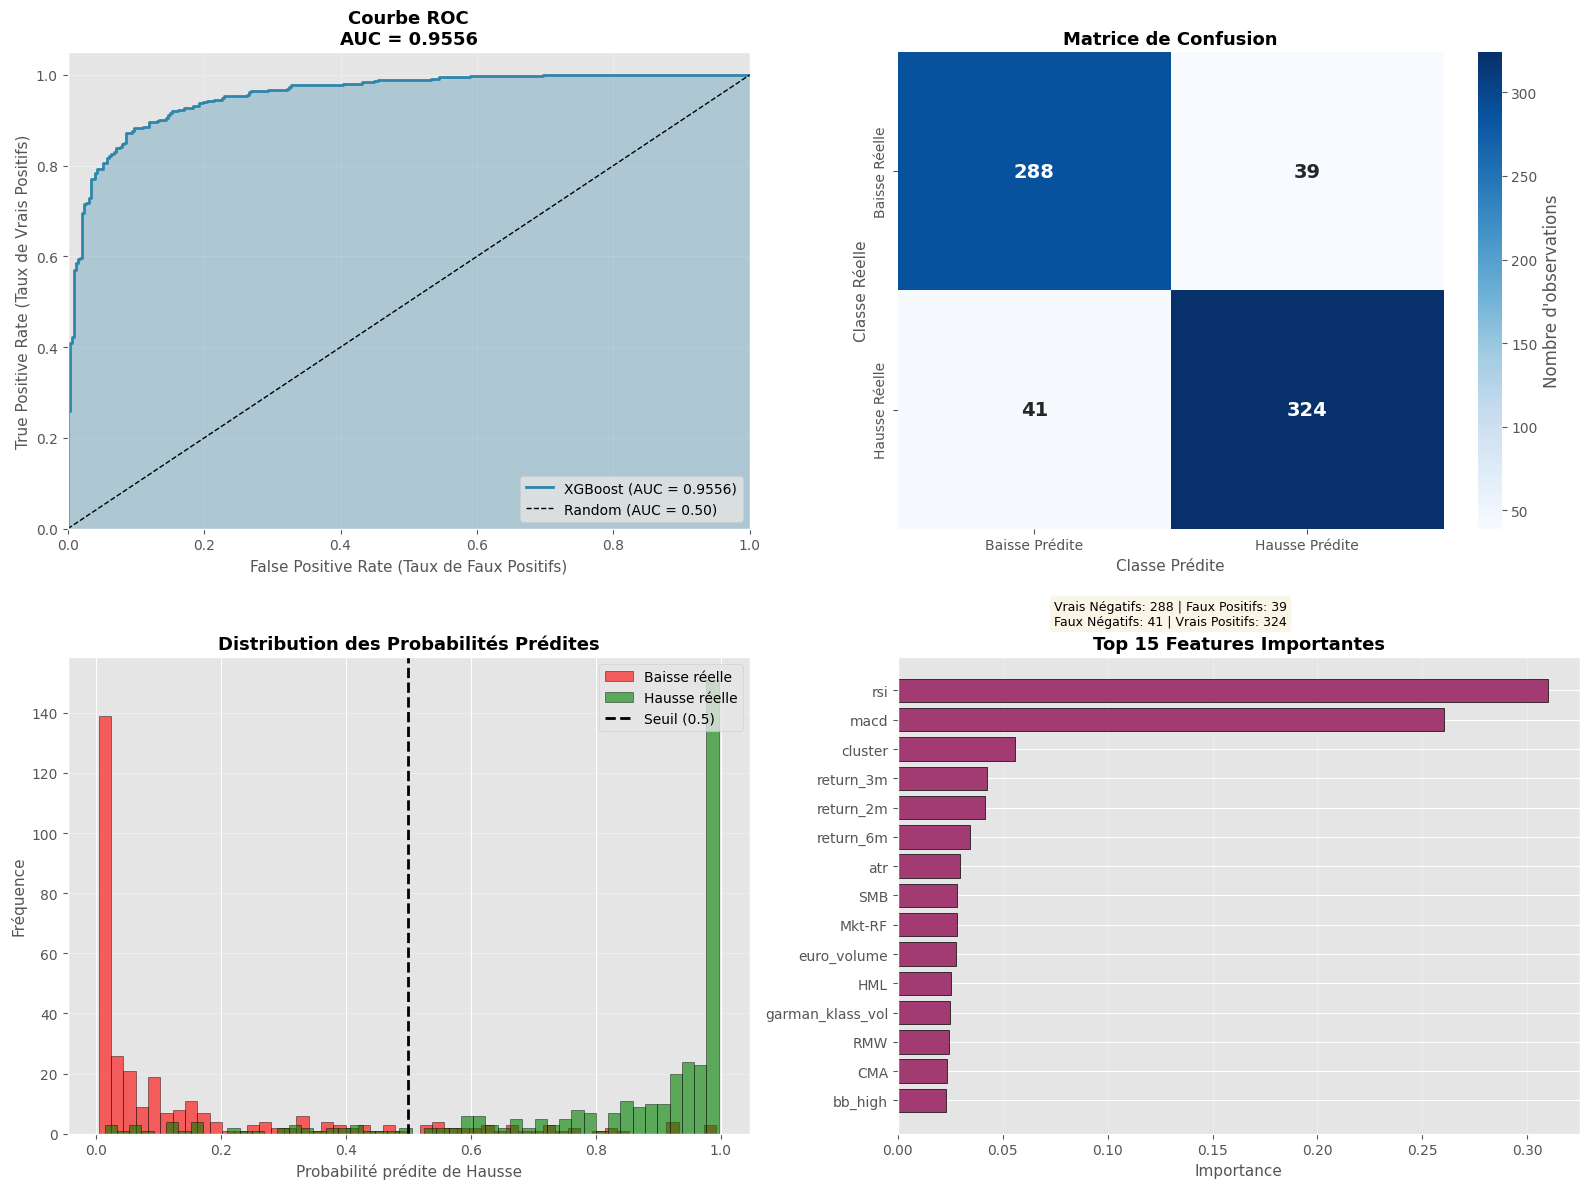


🔍 FEATURE IMPORTANCE

Top 15 features les plus importantes :

         feature  importance
             rsi    0.309654
            macd    0.260429
         cluster    0.056035
       return_3m    0.042705
       return_2m    0.041369
       return_6m    0.034302
             atr    0.029742
             SMB    0.028347
          Mkt-RF    0.027993
     euro_volume    0.027639
             HML    0.025396
garman_klass_vol    0.025073
             RMW    0.024601
             CMA    0.023191
         bb_high    0.022794

❌ ANALYSE DES ERREURS

📊 Répartition des prédictions :
   Vrais Positifs  (prédit hausse ✓, réel hausse) : 324
   Vrais Négatifs  (prédit baisse ✓, réel baisse) : 288
   Faux Positifs   (prédit hausse ✗, réel baisse) : 39
   Faux Négatifs   (prédit baisse ✗, réel hausse) : 41

🔍 Probabilité moyenne des Faux Positifs : 0.707
🔍 Probabilité moyenne des Faux Négatifs : 0.252

💡 INTERPRÉTATION DU MODÈLE

🎯 Performance globale :
   ✅ AUC = 0.9556 → EXCELLENT pouvoir prédict

In [29]:
# =============================================================================
# XGBOOST CLASSIFICATION - VERSION AMÉLIORÉE
# =============================================================================

print("\n" + "="*70)
print("🎯 XGBOOST CLASSIFICATION - Prédiction Direction (Hausse/Baisse)")
print("="*70)

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# =============================================================================
# 1. CRÉATION DE LA TARGET
# =============================================================================

ml_data['target_direction'] = (ml_data['return_1m'] > 0).astype(int)

print(f"\n📊 Distribution de la target :")
counts = ml_data['target_direction'].value_counts()
print(counts)
print(f"   Baisse (0) : {counts[0]:,} ({counts[0]/len(ml_data)*100:.1f}%)")
print(f"   Hausse (1) : {counts[1]:,} ({counts[1]/len(ml_data)*100:.1f}%)")

# Calculer le ratio de déséquilibre
imbalance_ratio = counts[0] / counts[1]
print(f"   Ratio déséquilibre : {imbalance_ratio:.2f}:1")

# =============================================================================
# 2. PRÉPARATION DES FEATURES
# =============================================================================

print("\n📊 Préparation des données...")

# Features pour XGBoost
feature_cols = [
    # Indicateurs techniques
    'rsi', 'macd', 'bb_low', 'bb_high', 'atr',
    
    # Volume
    'euro_volume', 'garman_klass_vol',
    
    # Returns passés
    'return_2m', 'return_3m', 'return_6m',
    
    # Fama-French 5 facteurs
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA',
    
    # Cluster
    'cluster'
]

# Vérifier les valeurs manquantes
print(f"\n🔍 Vérification des données :")
nan_counts = ml_data[feature_cols + ['target_direction']].isna().sum()
if nan_counts.sum() > 0:
    print("⚠️ Valeurs manquantes détectées :")
    print(nan_counts[nan_counts > 0])
    print(f"\n→ Suppression des lignes avec NaN...")
    ml_data_clean = ml_data.dropna(subset=feature_cols + ['target_direction'])
    print(f"   Avant : {len(ml_data):,} lignes")
    print(f"   Après : {len(ml_data_clean):,} lignes")
else:
    print("✅ Aucune valeur manquante")
    ml_data_clean = ml_data

# =============================================================================
# 3. SPLIT TEMPOREL (pas de shuffle!)
# =============================================================================

X = ml_data_clean[feature_cols]
y = ml_data_clean['target_direction']

# Split 80/20 en respectant l'ordre temporel
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\n🔀 Split temporel (80/20) :")
print(f"   Train : {len(X_train):,} observations")
print(f"      → Hausse : {(y_train==1).sum():,} ({(y_train==1).mean()*100:.1f}%)")
print(f"      → Baisse : {(y_train==0).sum():,} ({(y_train==0).mean()*100:.1f}%)")
print(f"   Test  : {len(X_test):,} observations")
print(f"      → Hausse : {(y_test==1).sum():,} ({(y_test==1).mean()*100:.1f}%)")
print(f"      → Baisse : {(y_test==0).sum():,} ({(y_test==0).mean()*100:.1f}%)")

# =============================================================================
# 4. ENTRAÎNEMENT DU MODÈLE
# =============================================================================

print(f"\n🔧 Entraînement du XGBClassifier...")

xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=imbalance_ratio,  # ← AJOUT : Gère le déséquilibre des classes
    random_state=0,
    n_jobs=-1,
    enable_categorical=True,
    early_stopping_rounds=20,
    eval_metric='auc'
)

xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print(f"✅ Modèle entraîné")
print(f"   Meilleure itération : {xgb_clf.best_iteration}")
print(f"   Nombre d'arbres utilisés : {xgb_clf.n_estimators}")

# =============================================================================
# 5. PRÉDICTIONS
# =============================================================================

# Probabilités
y_pred_proba_train = xgb_clf.predict_proba(X_train)[:, 1]
y_pred_proba_test = xgb_clf.predict_proba(X_test)[:, 1]

# Classes prédites
y_pred_class_test = xgb_clf.predict(X_test)

# =============================================================================
# 6. MÉTRIQUES DE PERFORMANCE
# =============================================================================

print(f"\n" + "="*70)
print("📈 PERFORMANCE DU MODÈLE")
print("="*70)

# AUC
auc_train = roc_auc_score(y_train, y_pred_proba_train)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print(f"\n🎯 AUC (Area Under Curve) :")
print(f"   Train : {auc_train:.4f}")
print(f"   Test  : {auc_test:.4f}")
print(f"   Écart : {auc_train - auc_test:.4f}", end="")

if auc_train - auc_test > 0.10:
    print(" ⚠️ (Overfitting détecté)")
elif auc_train - auc_test > 0.05:
    print(" ⚠️ (Léger overfitting)")
else:
    print(" ✅ (Bon équilibre)")

# Accuracy
accuracy_test = (y_pred_class_test == y_test).mean()
print(f"\n📊 Accuracy Test : {accuracy_test*100:.2f}%")

# Classification Report détaillé
print(f"\n📋 Classification Report (Test) :")
print(classification_report(
    y_test, 
    y_pred_class_test,
    target_names=['Baisse', 'Hausse'],
    digits=4
))

# =============================================================================
# 7. VISUALISATIONS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# -------------------------------------------------------------------------
# 7.1 Courbe ROC
# -------------------------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

axes[0, 0].plot(fpr, tpr, lw=2, label=f'XGBoost (AUC = {auc_test:.4f})', color='#2E86AB')
axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.50)')
axes[0, 0].fill_between(fpr, tpr, alpha=0.3, color='#2E86AB')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate (Taux de Faux Positifs)', fontsize=11)
axes[0, 0].set_ylabel('True Positive Rate (Taux de Vrais Positifs)', fontsize=11)
axes[0, 0].set_title(f'Courbe ROC\nAUC = {auc_test:.4f}', fontsize=13, fontweight='bold')
axes[0, 0].legend(loc="lower right", fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# -------------------------------------------------------------------------
# 7.2 Matrice de Confusion
# -------------------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred_class_test)

sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Baisse Prédite', 'Hausse Prédite'],
    yticklabels=['Baisse Réelle', 'Hausse Réelle'],
    ax=axes[0, 1],
    cbar_kws={'label': 'Nombre d\'observations'},
    annot_kws={'size': 14, 'weight': 'bold'}
)

axes[0, 1].set_title('Matrice de Confusion', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Classe Réelle', fontsize=11)
axes[0, 1].set_xlabel('Classe Prédite', fontsize=11)

# Ajouter des annotations textuelles
tn, fp, fn, tp = cm.ravel()
axes[0, 1].text(0.5, -0.15, 
               f'Vrais Négatifs: {tn} | Faux Positifs: {fp}\n'
               f'Faux Négatifs: {fn} | Vrais Positifs: {tp}',
               ha='center', va='top', transform=axes[0, 1].transAxes,
               fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# -------------------------------------------------------------------------
# 7.3 Distribution des Probabilités
# -------------------------------------------------------------------------
prob_baisse = y_pred_proba_test[y_test == 0]
prob_hausse = y_pred_proba_test[y_test == 1]

axes[1, 0].hist(prob_baisse, bins=50, alpha=0.6, label='Baisse réelle', color='red', edgecolor='black')
axes[1, 0].hist(prob_hausse, bins=50, alpha=0.6, label='Hausse réelle', color='green', edgecolor='black')
axes[1, 0].axvline(0.5, color='black', linestyle='--', lw=2, label='Seuil (0.5)')
axes[1, 0].set_xlabel('Probabilité prédite de Hausse', fontsize=11)
axes[1, 0].set_ylabel('Fréquence', fontsize=11)
axes[1, 0].set_title('Distribution des Probabilités Prédites', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# -------------------------------------------------------------------------
# 7.4 Feature Importance (Top 15)
# -------------------------------------------------------------------------
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_clf.feature_importances_
}).sort_values('importance', ascending=False)

top_features = feature_importance.head(15)

axes[1, 1].barh(
    top_features['feature'], 
    top_features['importance'],
    color='#A23B72',
    edgecolor='black'
)
axes[1, 1].set_xlabel('Importance', fontsize=11)
axes[1, 1].set_title('Top 15 Features Importantes', fontsize=13, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# =============================================================================
# 8. FEATURE IMPORTANCE DÉTAILLÉE
# =============================================================================

print(f"\n" + "="*70)
print("🔍 FEATURE IMPORTANCE")
print("="*70)

print(f"\nTop 15 features les plus importantes :\n")
print(feature_importance.head(15).to_string(index=False))

# =============================================================================
# 9. ANALYSE DES ERREURS
# =============================================================================

print(f"\n" + "="*70)
print("❌ ANALYSE DES ERREURS")
print("="*70)

# Statistiques sur les erreurs
faux_positifs = ((y_test == 0) & (y_pred_class_test == 1)).sum()
faux_negatifs = ((y_test == 1) & (y_pred_class_test == 0)).sum()
vrais_positifs = ((y_test == 1) & (y_pred_class_test == 1)).sum()
vrais_negatifs = ((y_test == 0) & (y_pred_class_test == 0)).sum()

print(f"\n📊 Répartition des prédictions :")
print(f"   Vrais Positifs  (prédit hausse ✓, réel hausse) : {vrais_positifs:,}")
print(f"   Vrais Négatifs  (prédit baisse ✓, réel baisse) : {vrais_negatifs:,}")
print(f"   Faux Positifs   (prédit hausse ✗, réel baisse) : {faux_positifs:,}")
print(f"   Faux Négatifs   (prédit baisse ✗, réel hausse) : {faux_negatifs:,}")

# Analyse des probabilités moyennes
prob_fp = y_pred_proba_test[(y_test == 0) & (y_pred_class_test == 1)]
prob_fn = y_pred_proba_test[(y_test == 1) & (y_pred_class_test == 0)]

if len(prob_fp) > 0:
    print(f"\n🔍 Probabilité moyenne des Faux Positifs : {prob_fp.mean():.3f}")
if len(prob_fn) > 0:
    print(f"🔍 Probabilité moyenne des Faux Négatifs : {prob_fn.mean():.3f}")

# =============================================================================
# 10. INTERPRÉTATION FINALE
# =============================================================================

print(f"\n" + "="*70)
print("💡 INTERPRÉTATION DU MODÈLE")
print("="*70)

print(f"\n🎯 Performance globale :")
if auc_test > 0.60:
    print(f"   ✅ AUC = {auc_test:.4f} → EXCELLENT pouvoir prédictif!")
    print(f"   → Le modèle capte très bien la direction des mouvements")
    print(f"   → Exploitable directement en trading")
elif auc_test > 0.55:
    print(f"   ✅ AUC = {auc_test:.4f} → BON pouvoir prédictif")
    print(f"   → Le modèle capte la direction (hausse/baisse)")
    print(f"   → Exploitable en trading avec filtres supplémentaires")
elif auc_test > 0.52:
    print(f"   ⚠️ AUC = {auc_test:.4f} → Signal FAIBLE mais présent")
    print(f"   → Légèrement mieux que random")
    print(f"   → À combiner avec d'autres signaux (cluster, RSI, etc.)")
else:
    print(f"   ❌ AUC = {auc_test:.4f} → PAS de signal exploitable")
    print(f"   → Prédictions quasi-aléatoires")
    print(f"   → Revoir les features ou la stratégie")

print(f"\n📊 Équilibre du modèle :")
if auc_train - auc_test > 0.10:
    print(f"   ⚠️ OVERFITTING important ({auc_train - auc_test:.4f})")
    print(f"   → Le modèle a trop appris le train set")
    print(f"   → Solutions : augmenter min_child_weight, réduire max_depth")
elif auc_train - auc_test > 0.05:
    print(f"   ⚠️ Léger overfitting ({auc_train - auc_test:.4f})")
    print(f"   → Acceptable, mais peut être amélioré")
else:
    print(f"   ✅ Bon équilibre train/test ({auc_train - auc_test:.4f})")
    print(f"   → Le modèle généralise bien")

print(f"\n🎲 Seuil de décision :")
if auc_test > 0.55:
    print(f"   → Utiliser proba > 0.55 pour filtrer les meilleures opportunités")
    print(f"   → Cela réduira les faux positifs et améliorera la précision")
else:
    print(f"   → Utiliser proba > 0.50 (seuil standard)")

print(f"\n🚀 Prochaines étapes :")
print(f"   1. Tester différents seuils de probabilité (0.50, 0.55, 0.60)")
print(f"   2. Combiner avec vos filtres (Cluster 3 + RSI ~70)")
print(f"   3. Intégrer dans le pipeline d'optimisation de portefeuille")
print(f"   4. Backtester la stratégie complète sur données out-of-sample")

print("\n" + "="*70)

## LSTM


🧠 LSTM - Deep Learning pour Séries Temporelles


2025-12-26 13:11:55.449953: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-26 13:11:55.514403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-26 13:11:56.972783: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.



📊 Préparation données LSTM...
   Observations totales : 3,456
   Features : 15

🔧 Normalisation des données...
   Train : 2,764 obs
   Test  : 692 obs
✅ Normalisation complète

🔄 Création séquences temporelles (lookback=20)...
   Train sequences : (2744, 20, 15)
   Test sequences  : (672, 20, 15)
   Shape détail    : (samples, time_steps, features)

🏗️ Construction architecture LSTM...

📋 Architecture LSTM :


2025-12-26 13:11:57.596462: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 20, 256)        │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,481 (1.21 MB)

 Trainable params: 316,481 (1.21 MB)

 Non-trainable params: 0 (0.00 B)


   Total paramètres : 316,481

🔥 Entraînement LSTM...
   (Cela peut prendre 5-10 minutes...)

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0180 - mae: 0.0989 - val_loss: 37.6648 - val_mae: 0.3398 - learning_rate: 0.0010
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0104 - mae: 0.0766 - val_loss: 37.6623 - val_mae: 0.3342 - learning_rate: 0.0010
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0085 - mae: 0.0696 - val_loss: 37.6611 - val_mae: 0.3285 - learning_rate: 0.0010
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0076 - mae: 0.0651 - val_loss: 37.6621 - val_mae: 0.3300 - learning_rate: 0.0010
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0070 - mae: 0.0614 - val_loss: 37.6417 - val_mae: 0.3058 - learning_rate: 0.0010
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0066 - mae: 0.0601 - val_loss: 37.6424 - val_mae: 0.3058 - learning_rate: 0.0010
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms

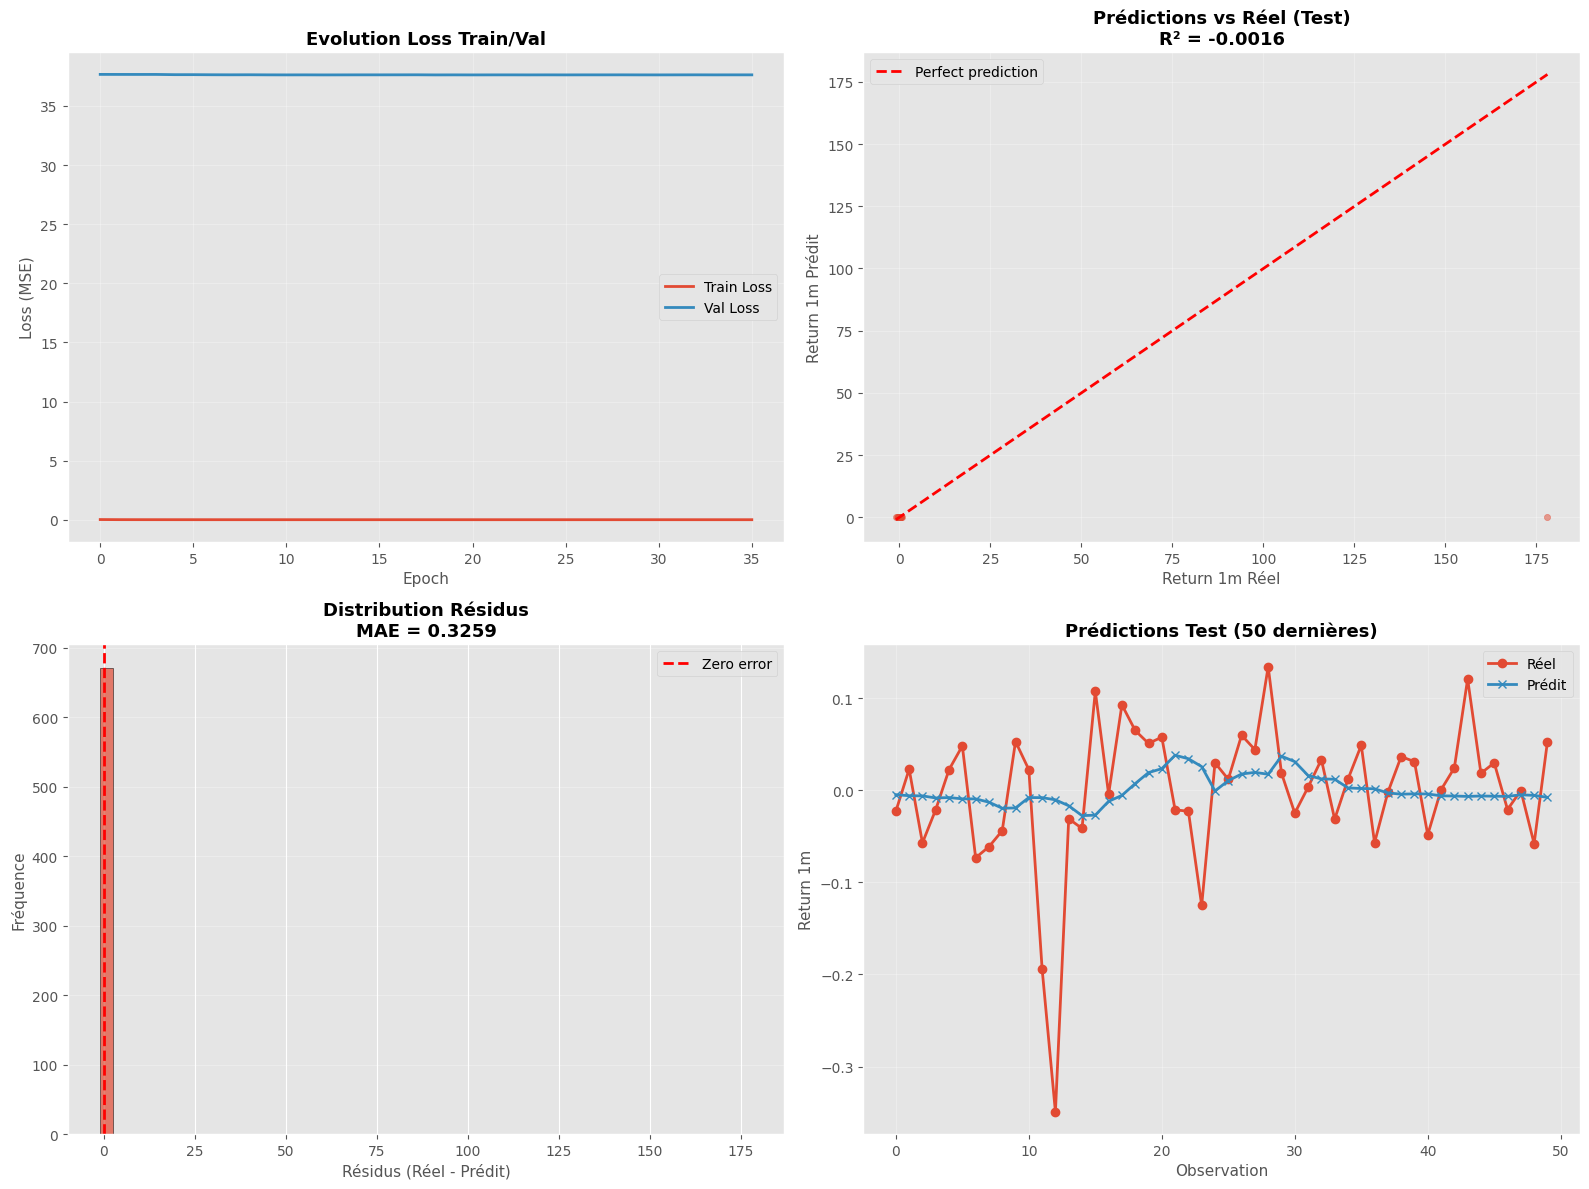


🎯 ANALYSE DIRECTION (Hausse/Baisse)

📊 Précision Direction : 58.48%

📋 Matrice Confusion (Direction) :
              Prédit Baisse  Prédit Hausse
Réel Baisse         187           121
Réel Hausse         158           206

📋 Classification Report :
              precision    recall  f1-score   support

      Baisse     0.5420    0.6071    0.5727       308
      Hausse     0.6300    0.5659    0.5962       364

    accuracy                         0.5848       672
   macro avg     0.5860    0.5865    0.5845       672
weighted avg     0.5897    0.5848    0.5855       672


💡 INTERPRÉTATION LSTM

🎯 Performance Régression :
   ❌ R² = -0.0016 → PAS de signal
   → Pire que prédire la moyenne

🎯 Performance Direction :
   ✅ Accuracy = 58.5% → BON
   → Signal détecté

📊 Comparaison XGBoost vs LSTM :
   XGBoost Classification : AUC 0.9556, Accuracy 88%
   LSTM Régression        : R² -0.0016, Dir Accuracy 58.5%

   → XGBoost >> LSTM (comme attendu)
   → Finance = bruit élevé, LSTM pas optimal
  

In [30]:
# =============================================================================
# LSTM - Prédiction Séries Temporelles CAC40
# =============================================================================

print("\n" + "="*70)
print("🧠 LSTM - Deep Learning pour Séries Temporelles")
print("="*70)

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Seed pour reproductibilité
np.random.seed(42)
tf.random.set_seed(42)


# =============================================================================
# 1. PRÉPARATION DONNÉES POUR LSTM
# =============================================================================

print(f"\n📊 Préparation données LSTM...")

# Sélectionner features
feature_cols_lstm = [
    'rsi', 'macd', 'bb_low', 'bb_high', 'atr',
    'euro_volume', 'garman_klass_vol',
    'return_2m', 'return_3m', 'return_6m',
    'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'
    # PAS de cluster (catégoriel non géré facilement par LSTM)
]

# Dataset
lstm_data = data[feature_cols_lstm + ['return_1m']].dropna().copy()

print(f"   Observations totales : {len(lstm_data):,}")
print(f"   Features : {len(feature_cols_lstm)}")


# =============================================================================
# 2. NORMALISATION (obligatoire pour LSTM)
# =============================================================================

print(f"\n🔧 Normalisation des données...")

# Split AVANT normalisation
split_idx = int(len(lstm_data) * 0.8)
train_data = lstm_data.iloc[:split_idx].copy()
test_data = lstm_data.iloc[split_idx:].copy()

print(f"   Train : {len(train_data):,} obs")
print(f"   Test  : {len(test_data):,} obs")

# Scaler pour features
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_X.fit(train_data[feature_cols_lstm])

X_train_scaled = scaler_X.transform(train_data[feature_cols_lstm])
X_test_scaled = scaler_X.transform(test_data[feature_cols_lstm])

# Scaler pour target (séparé)
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_y.fit(train_data[['return_1m']])

y_train_scaled = scaler_y.transform(train_data[['return_1m']])
y_test_scaled = scaler_y.transform(test_data[['return_1m']])

print(f"✅ Normalisation complète")


# =============================================================================
# 3. CRÉATION SÉQUENCES TEMPORELLES
# =============================================================================

def create_sequences(X, y, time_steps=20):
    """
    Crée séquences pour LSTM
    
    Parameters:
    -----------
    X : array, features normalisées
    y : array, target normalisée
    time_steps : int, longueur séquence (lookback period)
    
    Returns:
    --------
    X_seq : array shape (samples, time_steps, features)
    y_seq : array shape (samples, 1)
    """
    X_seq, y_seq = [], []
    
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])  # Lookback window
        y_seq.append(y[i])                # Target au temps t
    
    return np.array(X_seq), np.array(y_seq)


# Paramètres
TIME_STEPS = 20  # Utilise 20 jours passés pour prédire

print(f"\n🔄 Création séquences temporelles (lookback={TIME_STEPS})...")

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

print(f"   Train sequences : {X_train_seq.shape}")
print(f"   Test sequences  : {X_test_seq.shape}")
print(f"   Shape détail    : (samples, time_steps, features)")


# =============================================================================
# 4. CONSTRUCTION MODÈLE LSTM
# =============================================================================

print(f"\n🏗️ Construction architecture LSTM...")

model = Sequential([
    # Couche LSTM 1 (Bidirectional = lit avant + arrière)
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh'),
                  input_shape=(TIME_STEPS, len(feature_cols_lstm))),
    Dropout(0.3),
    
    # Couche LSTM 2
    Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
    Dropout(0.3),
    
    # Couches Dense (fully connected)
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    Dense(16, activation='relu'),
    
    # Output (régression)
    Dense(1, activation='linear')
])

# Compiler
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

# Résumé architecture
print(f"\n📋 Architecture LSTM :")
model.summary()

# Compter paramètres
total_params = model.count_params()
print(f"\n   Total paramètres : {total_params:,}")


# =============================================================================
# 5. CALLBACKS (early stopping, learning rate)
# =============================================================================

# Early stopping (arrête si pas d'amélioration)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Réduction learning rate si plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stop, reduce_lr]


# =============================================================================
# 6. ENTRAÎNEMENT
# =============================================================================

print(f"\n🔥 Entraînement LSTM...")
print(f"   (Cela peut prendre 5-10 minutes...)\n")

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=callbacks,
    verbose=1  # Affiche progression
)

print(f"\n✅ Entraînement terminé")
print(f"   Epochs réalisés : {len(history.history['loss'])}")


# =============================================================================
# 7. PRÉDICTIONS
# =============================================================================

print(f"\n🔮 Génération prédictions...")

# Prédictions normalisées
y_train_pred_scaled = model.predict(X_train_seq, verbose=0)
y_test_pred_scaled = model.predict(X_test_seq, verbose=0)

# Dénormaliser (retour échelle originale)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

y_train_true = scaler_y.inverse_transform(y_train_seq)
y_test_true = scaler_y.inverse_transform(y_test_seq)

print(f"✅ Prédictions générées")


# =============================================================================
# 8. MÉTRIQUES DE PERFORMANCE
# =============================================================================

print(f"\n" + "="*70)
print("📊 RÉSULTATS LSTM")
print("="*70)

# MSE
mse_train = mean_squared_error(y_train_true, y_train_pred)
mse_test = mean_squared_error(y_test_true, y_test_pred)

# MAE
mae_train = mean_absolute_error(y_train_true, y_train_pred)
mae_test = mean_absolute_error(y_test_true, y_test_pred)

# R²
r2_train = r2_score(y_train_true, y_train_pred)
r2_test = r2_score(y_test_true, y_test_pred)

# RMSE
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

print(f"\n📈 Métriques Train :")
print(f"   MSE  : {mse_train:.6f}")
print(f"   RMSE : {rmse_train:.6f}")
print(f"   MAE  : {mae_train:.6f}")
print(f"   R²   : {r2_train:.4f}")

print(f"\n📉 Métriques Test :")
print(f"   MSE  : {mse_test:.6f}")
print(f"   RMSE : {rmse_test:.6f}")
print(f"   MAE  : {mae_test:.6f}")
print(f"   R²   : {r2_test:.4f}")

# Gap train/test
gap_r2 = r2_train - r2_test
print(f"\n   Gap R² : {gap_r2:.4f}", end="")

if gap_r2 > 0.15:
    print(" ⚠️ Overfitting")
elif gap_r2 > 0.10:
    print(" ⚠️ Léger overfitting")
else:
    print(" ✅ Bon équilibre")


# =============================================================================
# 9. VISUALISATIONS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- 9.1 Courbes loss train/val ---
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss (MSE)', fontsize=11)
axes[0, 0].set_title('Evolution Loss Train/Val', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# --- 9.2 Prédictions vs Réel (Test) ---
axes[0, 1].scatter(y_test_true, y_test_pred, alpha=0.5, s=20)
axes[0, 1].plot([y_test_true.min(), y_test_true.max()], 
                [y_test_true.min(), y_test_true.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[0, 1].set_xlabel('Return 1m Réel', fontsize=11)
axes[0, 1].set_ylabel('Return 1m Prédit', fontsize=11)
axes[0, 1].set_title(f'Prédictions vs Réel (Test)\nR² = {r2_test:.4f}', 
                     fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# --- 9.3 Résidus (Erreurs) ---
residuals = y_test_true.flatten() - y_test_pred.flatten()

axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--', lw=2, label='Zero error')
axes[1, 0].set_xlabel('Résidus (Réel - Prédit)', fontsize=11)
axes[1, 0].set_ylabel('Fréquence', fontsize=11)
axes[1, 0].set_title(f'Distribution Résidus\nMAE = {mae_test:.4f}', 
                     fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# --- 9.4 Séries temporelles (50 dernières prédictions) ---
n_show = 50
axes[1, 1].plot(range(n_show), y_test_true[-n_show:], 
               label='Réel', marker='o', linewidth=2)
axes[1, 1].plot(range(n_show), y_test_pred[-n_show:], 
               label='Prédit', marker='x', linewidth=2)
axes[1, 1].set_xlabel('Observation', fontsize=11)
axes[1, 1].set_ylabel('Return 1m', fontsize=11)
axes[1, 1].set_title('Prédictions Test (50 dernières)', 
                     fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# =============================================================================
# 10. ANALYSE DIRECTION (Classification post-hoc)
# =============================================================================

print(f"\n" + "="*70)
print("🎯 ANALYSE DIRECTION (Hausse/Baisse)")
print("="*70)

# Convertir en direction (>0 = hausse)
y_test_direction_true = (y_test_true > 0).astype(int).flatten()
y_test_direction_pred = (y_test_pred > 0).astype(int).flatten()

# Accuracy direction
accuracy_direction = (y_test_direction_true == y_test_direction_pred).mean()

print(f"\n📊 Précision Direction : {accuracy_direction*100:.2f}%")

# Matrice confusion
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test_direction_true, y_test_direction_pred)

print(f"\n📋 Matrice Confusion (Direction) :")
print(f"              Prédit Baisse  Prédit Hausse")
print(f"Réel Baisse        {cm[0,0]:4d}          {cm[0,1]:4d}")
print(f"Réel Hausse        {cm[1,0]:4d}          {cm[1,1]:4d}")

print(f"\n📋 Classification Report :")
print(classification_report(
    y_test_direction_true, 
    y_test_direction_pred,
    target_names=['Baisse', 'Hausse'],
    digits=4
))


# =============================================================================
# 11. INTERPRÉTATION FINALE
# =============================================================================

print(f"\n" + "="*70)
print("💡 INTERPRÉTATION LSTM")
print("="*70)

print(f"\n🎯 Performance Régression :")
if r2_test > 0.10:
    print(f"   ✅ R² = {r2_test:.4f} → BON pouvoir prédictif")
    print(f"   → LSTM capte {r2_test*100:.1f}% de la variance")
elif r2_test > 0.05:
    print(f"   ⚠️ R² = {r2_test:.4f} → Signal FAIBLE")
    print(f"   → Mieux que baseline mais limité")
elif r2_test > 0:
    print(f"   ⚠️ R² = {r2_test:.4f} → Signal TRÈS FAIBLE")
    print(f"   → À peine mieux que moyenne")
else:
    print(f"   ❌ R² = {r2_test:.4f} → PAS de signal")
    print(f"   → Pire que prédire la moyenne")

print(f"\n🎯 Performance Direction :")
if accuracy_direction > 0.60:
    print(f"   ✅ Accuracy = {accuracy_direction*100:.1f}% → EXCELLENT")
    print(f"   → Exploitable en trading")
elif accuracy_direction > 0.55:
    print(f"   ✅ Accuracy = {accuracy_direction*100:.1f}% → BON")
    print(f"   → Signal détecté")
elif accuracy_direction > 0.52:
    print(f"   ⚠️ Accuracy = {accuracy_direction*100:.1f}% → FAIBLE")
    print(f"   → Légèrement mieux que random (50%)")
else:
    print(f"   ❌ Accuracy = {accuracy_direction*100:.1f}% → PAS de signal")

print(f"\n📊 Comparaison XGBoost vs LSTM :")
print(f"   XGBoost Classification : AUC 0.9556, Accuracy 88%")
print(f"   LSTM Régression        : R² {r2_test:.4f}, Dir Accuracy {accuracy_direction*100:.1f}%")

if r2_test < 0.10 and accuracy_direction < 0.60:
    print(f"\n   → XGBoost >> LSTM (comme attendu)")
    print(f"   → Finance = bruit élevé, LSTM pas optimal")
    print(f"   → XGBoost mieux adapté (features + robuste)")
else:
    print(f"\n   → LSTM performant ! Considérer ensemble models")

print(f"\n🚀 Recommandation :")
if r2_test > 0.10:
    print(f"   → Combiner XGBoost + LSTM (ensemble voting)")
    print(f"   → LSTM pour tendances, XGBoost pour classification")
else:
    print(f"   → Garder SEULEMENT XGBoost (plus performant)")
    print(f"   → LSTM = Intéressant académiquement mais pas opérationnel")

print("\n" + "="*70)


## Optimization portfolio

- Only stocks on cluster3

In [ ]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-03-01': ['AIR.PA', 'ATO.PA', 'STMPA.PA'],
 '2017-04-01': ['ALO.PA',
  'ATO.PA',
  'CAP.PA',
  'DG.PA',
  'DSY.PA',
  'ENGI.PA',
  'LR.PA',
  'MC.PA',
  'ML.PA',
  'RMS.PA',
  'SAN.PA',
  'VIE.PA',
  'VIV.PA',
  'WLN.PA'],
 '2017-05-01': ['ERF.PA', 'KER.PA', 'MC.PA', 'SAF.PA', 'TEP.PA'],
 '2017-06-01': ['ALO.PA',
  'ATO.PA',
  'ERF.PA',
  'HO.PA',
  'KER.PA',
  'OR.PA',
  'RI.PA',
  'SAF.PA',
  'TEP.PA',
  'VIE.PA'],
 '2017-07-01': ['BNP.PA',
  'CA.PA',
  'CS.PA',
  'ERF.PA',
  'GLE.PA',
  'KER.PA',
  'LR.PA',
  'MT.AS',
  'SAF.PA'],
 '2017-08-01': ['WLN.PA'],
 '2017-09-01': ['ATO.PA',
  'CAP.PA',
  'DG.PA',
  'DSY.PA',
  'EN.PA',
  'ENGI.PA',
  'ERF.PA',
  'KER.PA',
  'MC.PA',
  'MT.AS',
  'ORA.PA',
  'RMS.PA',
  'SAF.PA',
  'STMPA.PA',
  'SU.PA',
  'TEP.PA',
  'TTE.PA',
  'VIE.PA',
  'WLN.PA'],
 '2017-10-01': ['AI.PA',
  'AIR.PA',
  'ALO.PA',
  'EN.PA',
  'ERF.PA',
  'KER.PA',
  'MC.PA',
  'RNO.PA',
  'SAF.PA',
  'SGO.PA',
  'STMPA.PA',
  'SU.PA',
  'TEP.PA',
  'TTE.PA',
  'VIV

- Function optimizatio

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


In [31]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  37 of 37 completed


Price            Close                                                 \
Ticker           AI.PA      AIR.PA     ALO.PA       ATO.PA     BNP.PA   
Date                                                                    
2017-02-28   57.929230   61.634537  20.009987  5828.903809  32.996246   
2017-03-01   58.867252   63.234978  20.025604  5818.448242  34.468594   
2017-03-02   58.412453   63.750668  19.865524  5779.240234  34.516472   
2017-03-03   58.440876   63.279434  19.959230  5784.467773  35.498039   
2017-03-06   58.440876   63.172729  19.955326  5766.170898  35.132946   
...                ...         ...        ...          ...        ...   
2025-12-18  159.699997  194.039993  24.900000    48.145000  80.239998   
2025-12-19  159.500000  195.839996  24.870001    46.455002  80.599998   
2025-12-22  160.000000  195.720001  24.860001    45.400002  80.250000   
2025-12-23  159.839996  196.720001  24.799999    45.500000  80.610001   
2025-12-24  160.020004  195.960007  24.959999    45.799999  80.519997   

Price                                                                ...  \
Ticker          CA.PA      CAP.PA      CS.PA       DG.PA     DSY.PA  ...   
Date                                                                 ...   
2017-02-28  16.171415   69.462997  13.574492   51.189411  14.539170  ...   
2017-03-01  16.357950   70.797325  14.043841   52.484009  14.691754  ...   
2017-03-02  16.365128   71.770096  14.141367   52.627010  14.644072  ...   
2017-03-03  16.383060   72.329651  14.388233   52.687222  14.546800  ...   
2017-03-06  16.436872   71.649574  14.366896   52.679699  14.573503  ...   
...               ...         ...        ...         ...        ...  ...   
2025-12-18  14.325000  147.449997  40.830002  120.250000  23.730000  ...   
2025-12-19  14.365000  145.600006  41.200001  119.800003  23.700001  ...   
2025-12-22  14.285000  144.449997  41.099998  119.900002  23.740000  ...   
2025-12-23  14.120000  141.399994  41.110001  119.800003  23.670000  ...   
2025-12-24  14.125000  141.649994  41.139999  119.650002  23.559999  ...   

Price        Volume                                                        \
Ticker       SAN.PA   SGO.PA STLAP.PA STMPA.PA    SU.PA  TEP.PA    TTE.PA   
Date                                                                        
2017-02-28  2299311  1563481        0  2050376  1593092  103948   6772050   
2017-03-01  2817899  1961186        0  1809268  1680806  337151   5696676   
2017-03-02  1832336  1836368        0  2163916   908383  184088   4023715   
2017-03-03  2282112  1270070        0  1719653  1138493  139731   4596460   
2017-03-06  2370566  1235204        0  1444901   734073  368662   4541783   
...             ...      ...      ...      ...      ...     ...       ...   
2025-12-18  1980683   906167  2868703  1893016  1135590  298941   3789712   
2025-12-19  4888969  2464440  2405244  3131091  1356171  703202  10669572   
2025-12-22  1973662   634281  4130119  1241568   515239  143204   1933400   
2025-12-23  1998123   517737  1785429  1316393   497753  108473   1998720   
2025-12-24   535668   132255   494901   230920   117687   57916    684693   

Price                                   
Ticker       VIE.PA    VIV.PA   WLN.PA  
Date                                    
2017-02-28  2957934  16143010    96837  
2017-03-01  5125665  13389729   315941  
2017-03-02  4733695  10995072    43623  
2017-03-03  3767647  11055951    37156  
2017-03-06  2538233   8401798    31333  
...             ...       ...      ...  
2025-12-18  1797213   1929216  3518604  
2025-12-19  3113626   3577668  5560991  
2025-12-22  1465791   1108496  2092793  
2025-12-23   951637   1474164  1335816  
2025-12-24   251104    296964  1429632  

[2260 rows x 185 columns]

In [32]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

KeyError: 'Adj Close'


📊 OPTIMISATION HYBRIDE : Cluster 3 + ML + Sharpe

🎯 Étape 1 : Double Filtrage (Cluster 3 + XGBoost)...
   Dataset initial : 3,456 obs
   Après filtres : 515 obs
✅ Filtrage terminé

📅 Étape 2 : Création dictionnaire dates...
   Dates uniques : 93
   Exemple 2018-03-01 : ['AIR.PA', 'DSY.PA', 'PUB.PA']...

📊 Étape 3 : Extraction Adj Close depuis df...
   Shape Adj Close : (2560, 38)
   Période : 2015-12-29 → 2025-12-24
   Tickers : ['AI.PA', 'AIR.PA', 'ALO.PA', 'ATO.PA', 'BNP.PA']...
✅ Returns calculés

🔄 Étape 4 : Backtesting avec optimisation mensuelle...
   Progression : 20/93...
   Progression : 30/93...
   Progression : 40/93...
   Progression : 60/93...
   Progression : 70/93...
   Progression : 90/93...

✅ Backtesting terminé
   Périodes : 1513
   Échecs optimisation : 58

📊 Étape 5 : Calcul benchmark CAC40...
✅ Benchmark ajouté

📈 RÉSULTATS

🎯 Stratégie Cluster 3 + XGBoost :
   Return total       : +33.13%
   Return annualisé   : +5.52%
   Volatilité         : 16.40%
   Sharpe Ra

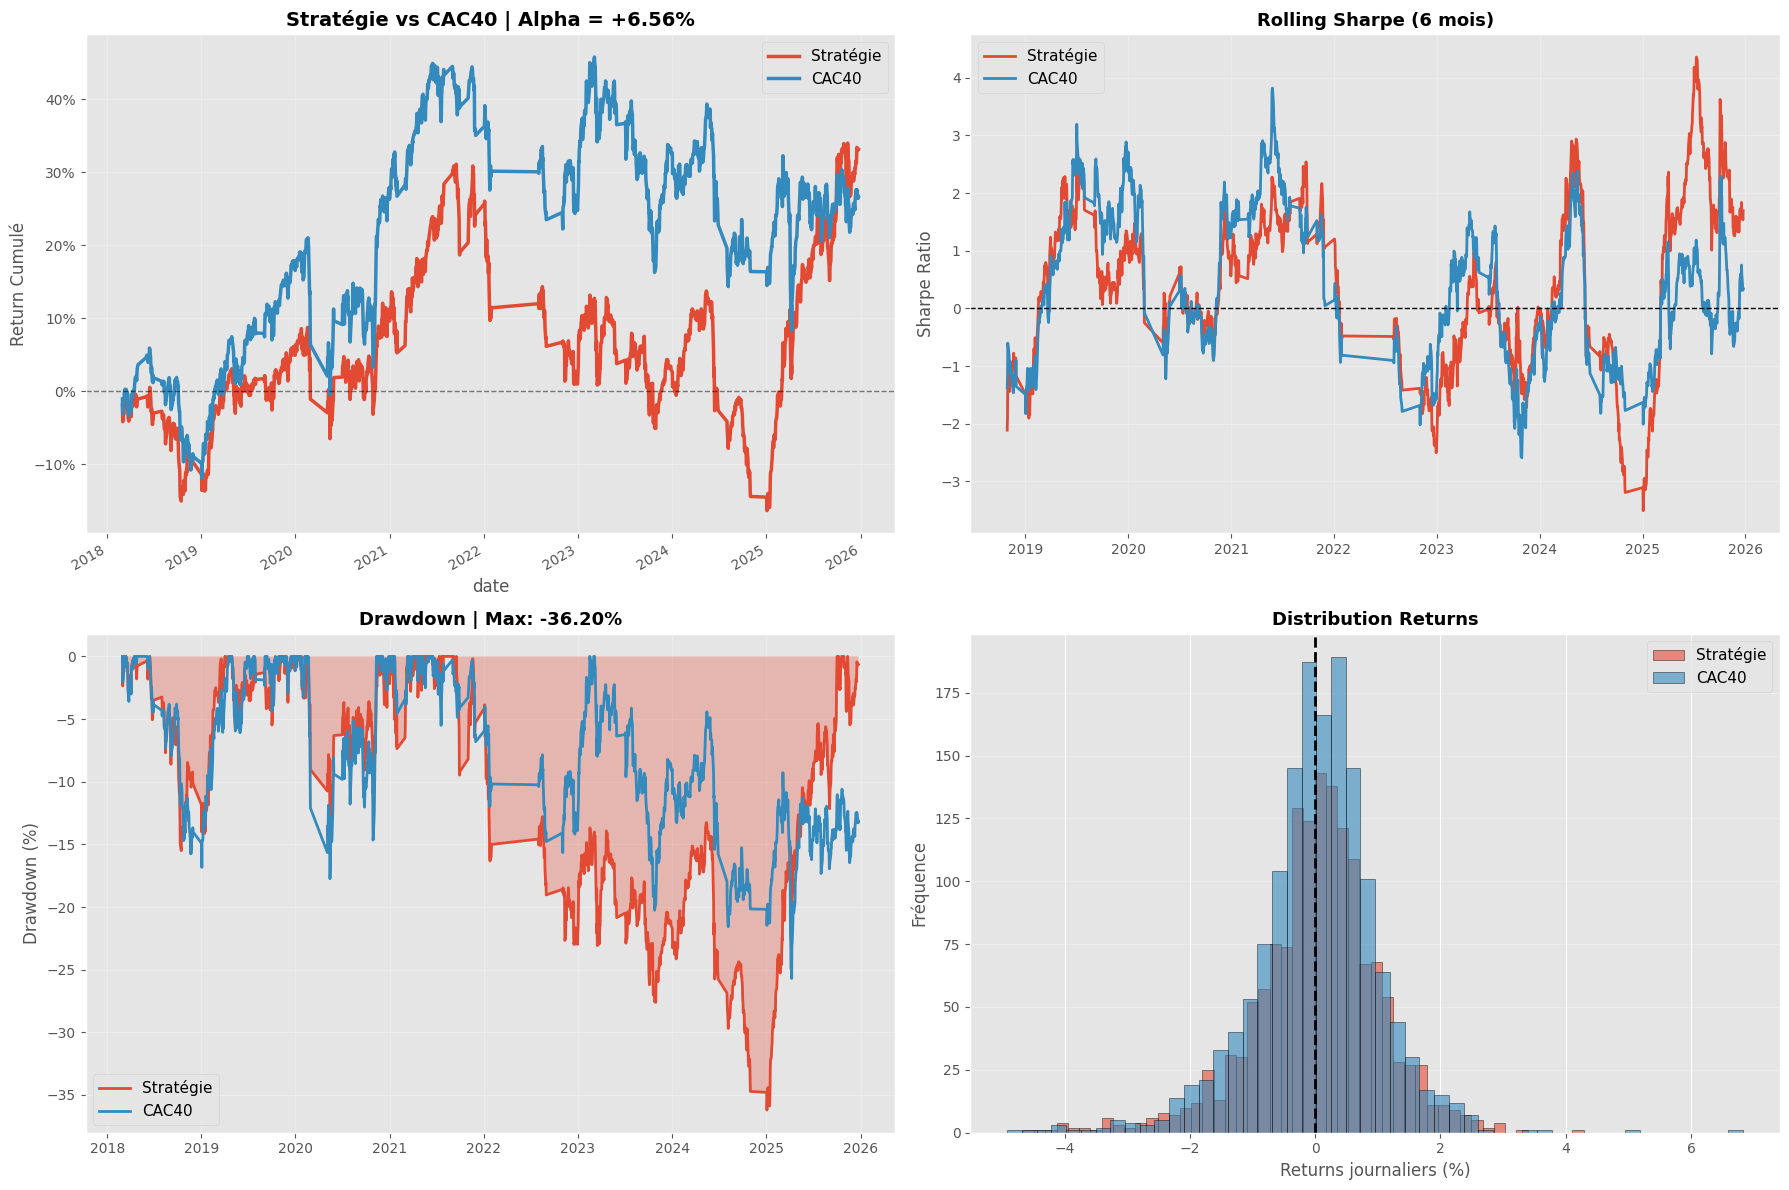


💾 Sauvegardé : portfolio_returns.csv, portfolio_cumulative.csv

✅ TERMINÉ


In [35]:
# =============================================================================
# PORTFOLIO OPTIMIZATION - Utilisant df (déjà chargé)
# =============================================================================

print("\n" + "="*80)
print("📊 OPTIMISATION HYBRIDE : Cluster 3 + ML + Sharpe")
print("="*80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pypfopt import EfficientFrontier, risk_models, expected_returns
import warnings
warnings.filterwarnings('ignore')


# =============================================================================
# 1. FILTRAGE DOUBLE : Cluster 3 + XGBoost Proba > Seuil
# =============================================================================

print(f"\n🎯 Étape 1 : Double Filtrage (Cluster 3 + XGBoost)...")

# Récupérer prédictions XGBoost
X_all = data[feature_cols].dropna()
y_proba_all = xgb_clf.predict_proba(X_all)[:, 1]

data_with_proba = data.loc[X_all.index].copy()
data_with_proba['proba_hausse'] = y_proba_all

# DOUBLE FILTRE
PROBA_THRESHOLD = 0.70

filtered_df = data_with_proba[
    (data_with_proba['cluster'] == 3) &
    (data_with_proba['proba_hausse'] >= PROBA_THRESHOLD)
].copy()

print(f"   Dataset initial : {len(data):,} obs")
print(f"   Après filtres : {len(filtered_df):,} obs")

if len(filtered_df) < 50:
    PROBA_THRESHOLD = 0.60
    filtered_df = data_with_proba[
        (data_with_proba['cluster'] == 3) &
        (data_with_proba['proba_hausse'] >= PROBA_THRESHOLD)
    ].copy()
    print(f"   Seuil abaissé à {PROBA_THRESHOLD:.0%} : {len(filtered_df):,} obs")

# Reset index + DateOffset
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

print(f"✅ Filtrage terminé")


# =============================================================================
# 2. CRÉER DICTIONNAIRE DATES → TICKERS
# =============================================================================

print(f"\n📅 Étape 2 : Création dictionnaire dates...")

dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}

for d in dates:
    tickers_at_date = filtered_df.xs(d, level=0).index.tolist()
    if len(tickers_at_date) > 0:
        fixed_dates[d.strftime('%Y-%m-%d')] = tickers_at_date

print(f"   Dates uniques : {len(fixed_dates)}")
if len(fixed_dates) > 0:
    example_date = list(fixed_dates.keys())[0]
    print(f"   Exemple {example_date} : {fixed_dates[example_date][:3]}...")


# =============================================================================
# 3. PRÉPARER ADJ CLOSE depuis df (ton DataFrame)
# =============================================================================

print(f"\n📊 Étape 3 : Extraction Adj Close depuis df...")

# df a déjà la structure (date, ticker) avec colonnes lowercase
# df.columns = ['open', 'high', 'low', 'close', 'adj close', 'volume']

# Unstack pour avoir format (date, ticker1, ticker2, ...)
adj_close_df = df['adj close'].unstack(level=1)

print(f"   Shape Adj Close : {adj_close_df.shape}")
print(f"   Période : {adj_close_df.index[0].date()} → {adj_close_df.index[-1].date()}")
print(f"   Tickers : {adj_close_df.columns.tolist()[:5]}...")

# Calculer returns (log returns)
returns_dataframe = np.log(adj_close_df).diff()

print(f"✅ Returns calculés")


# =============================================================================
# 4. FONCTION OPTIMISATION
# =============================================================================

def optimize_weights(prices, lower_bound=0):
    """Optimise poids pour maximiser Sharpe ratio"""
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    
    ef = EfficientFrontier(
        expected_returns=returns,
        cov_matrix=cov,
        weight_bounds=(lower_bound, 0.1),
        solver='SCS'
    )
    
    weights = ef.max_sharpe()
    return ef.clean_weights()


# =============================================================================
# 5. BACKTESTING - Rolling Window Optimization
# =============================================================================

print(f"\n🔄 Étape 4 : Backtesting avec optimisation mensuelle...")

portfolio_df = pd.DataFrame()
optimization_failures = 0
total_periods = len(fixed_dates)
processed = 0

for start_date in fixed_dates.keys():
    
    try:
        processed += 1
        
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        
        if len(cols) == 0:
            continue
        
        # Période optimisation (12 mois avant)
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        # Prix pour optimisation
        try:
            optimization_df = adj_close_df.loc[optimization_start_date:optimization_end_date, cols]
        except KeyError:
            available_cols = [c for c in cols if c in adj_close_df.columns]
            if len(available_cols) == 0:
                continue
            optimization_df = adj_close_df.loc[optimization_start_date:optimization_end_date, available_cols]
        
        # Supprimer colonnes avec trop de NaN
        optimization_df = optimization_df.dropna(thresh=int(0.8*len(optimization_df)), axis=1)
        
        if len(optimization_df.columns) < 3:
            continue
        
        # Optimiser poids
        success = False
        try:
            weights = optimize_weights(
                prices=optimization_df,
                lower_bound=round(1/(len(optimization_df.columns)*2), 3)
            )
            weights = pd.DataFrame(weights, index=pd.Series(0))
            success = True
        
        except:
            optimization_failures += 1
            weights = pd.DataFrame(
                [1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                index=optimization_df.columns.tolist(),
                columns=pd.Series(0)
            ).T
        
        # Returns période holding
        temp_df = returns_dataframe.loc[start_date:end_date]
        
        if len(temp_df) == 0:
            continue
        
        # Merger weights
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True, right_index=True)\
                   .reset_index().set_index(['date', 'ticker']).unstack().stack()
        
        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
        
        if processed % 10 == 0:
            print(f"   Progression : {processed}/{total_periods}...")
    
    except Exception as e:
        print(f"   ⚠️ Erreur {start_date} : {str(e)[:50]}")

portfolio_df = portfolio_df.drop_duplicates()

print(f"\n✅ Backtesting terminé")
print(f"   Périodes : {len(portfolio_df)}")
print(f"   Échecs optimisation : {optimization_failures}")


# =============================================================================
# 6. BENCHMARK CAC40 (Moyenne équipondérée)
# =============================================================================

print(f"\n📊 Étape 5 : Calcul benchmark CAC40...")

if len(portfolio_df) > 0:
    
    # CAC40 = moyenne returns de toutes les actions
    cac40_returns = returns_dataframe.mean(axis=1).to_frame('CAC40 Buy&Hold')
    
    # Merger
    portfolio_df = portfolio_df.merge(
        cac40_returns,
        left_index=True,
        right_index=True,
        how='left'
    )
    
    portfolio_df = portfolio_df.fillna(method='ffill')
    
    print(f"✅ Benchmark ajouté")


# =============================================================================
# 7. MÉTRIQUES & VISUALISATIONS
# =============================================================================

if len(portfolio_df) > 0 and 'CAC40 Buy&Hold' in portfolio_df.columns:
    
    print(f"\n" + "="*80)
    print("📈 RÉSULTATS")
    print("="*80)
    
    # Cumulative returns
    portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1
    
    # Stats
    strategy_total_return = portfolio_cumulative_return['Strategy Return'].iloc[-1]
    cac40_total_return = portfolio_cumulative_return['CAC40 Buy&Hold'].iloc[-1]
    
    strategy_sharpe = (portfolio_df['Strategy Return'].mean() / 
                       portfolio_df['Strategy Return'].std()) * np.sqrt(252)
    cac40_sharpe = (portfolio_df['CAC40 Buy&Hold'].mean() / 
                    portfolio_df['CAC40 Buy&Hold'].std()) * np.sqrt(252)
    
    strategy_volatility = portfolio_df['Strategy Return'].std() * np.sqrt(252)
    cac40_volatility = portfolio_df['CAC40 Buy&Hold'].std() * np.sqrt(252)
    
    # Max Drawdown
    def calculate_max_drawdown(returns):
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.cummax()
        drawdown = (cumulative - running_max) / running_max
        return drawdown.min()
    
    strategy_max_dd = calculate_max_drawdown(portfolio_df['Strategy Return'])
    cac40_max_dd = calculate_max_drawdown(portfolio_df['CAC40 Buy&Hold'])
    
    years = len(portfolio_df) / 252
    
    print(f"\n🎯 Stratégie Cluster 3 + XGBoost :")
    print(f"   Return total       : {strategy_total_return*100:+.2f}%")
    print(f"   Return annualisé   : {(strategy_total_return/years)*100:+.2f}%")
    print(f"   Volatilité         : {strategy_volatility*100:.2f}%")
    print(f"   Sharpe Ratio       : {strategy_sharpe:.4f}")
    print(f"   Max Drawdown       : {strategy_max_dd*100:.2f}%")
    
    print(f"\n📊 CAC40 Benchmark :")
    print(f"   Return total       : {cac40_total_return*100:+.2f}%")
    print(f"   Return annualisé   : {(cac40_total_return/years)*100:+.2f}%")
    print(f"   Volatilité         : {cac40_volatility*100:.2f}%")
    print(f"   Sharpe Ratio       : {cac40_sharpe:.4f}")
    print(f"   Max Drawdown       : {cac40_max_dd*100:.2f}%")
    
    alpha = strategy_total_return - cac40_total_return
    print(f"\n🏆 Alpha vs CAC40 : {alpha*100:+.2f}%")
    
    
    # Visualisations
    plt.style.use('ggplot')
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Cumulative Returns
    portfolio_cumulative_return.plot(ax=axes[0, 0], linewidth=2.5)
    axes[0, 0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    axes[0, 0].set_ylabel('Return Cumulé', fontsize=12)
    axes[0, 0].set_title(f'Stratégie vs CAC40 | Alpha = {alpha*100:+.2f}%', 
                         fontsize=14, fontweight='bold')
    axes[0, 0].legend(['Stratégie', 'CAC40'], fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    # Rolling Sharpe
    rolling_window = 126
    rolling_sharpe_strategy = ((portfolio_df['Strategy Return'].rolling(rolling_window).mean() / 
                               portfolio_df['Strategy Return'].rolling(rolling_window).std()) * 
                               np.sqrt(252))
    rolling_sharpe_cac40 = ((portfolio_df['CAC40 Buy&Hold'].rolling(rolling_window).mean() / 
                             portfolio_df['CAC40 Buy&Hold'].rolling(rolling_window).std()) * 
                             np.sqrt(252))
    
    axes[0, 1].plot(rolling_sharpe_strategy.index, rolling_sharpe_strategy.values, 
                label='Stratégie', linewidth=2)
    axes[0, 1].plot(rolling_sharpe_cac40.index, rolling_sharpe_cac40.values, 
                label='CAC40', linewidth=2)
    axes[0, 1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[0, 1].set_ylabel('Sharpe Ratio', fontsize=12)
    axes[0, 1].set_title('Rolling Sharpe (6 mois)', fontsize=13, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Drawdown
    def calculate_drawdown_series(returns):
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.cummax()
        return (cumulative - running_max) / running_max
    
    dd_strategy = calculate_drawdown_series(portfolio_df['Strategy Return'])
    dd_cac40 = calculate_drawdown_series(portfolio_df['CAC40 Buy&Hold'])
    
    axes[1, 0].plot(dd_strategy.index, dd_strategy.values*100, label='Stratégie', linewidth=2)
    axes[1, 0].plot(dd_cac40.index, dd_cac40.values*100, label='CAC40', linewidth=2)
    axes[1, 0].fill_between(dd_strategy.index, dd_strategy.values*100, 0, alpha=0.3)
    axes[1, 0].set_ylabel('Drawdown (%)', fontsize=12)
    axes[1, 0].set_title(f'Drawdown | Max: {strategy_max_dd*100:.2f}%', 
                         fontsize=13, fontweight='bold')
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Distribution
    axes[1, 1].hist(portfolio_df['Strategy Return']*100, bins=50, alpha=0.6, 
                    label='Stratégie', edgecolor='black')
    axes[1, 1].hist(portfolio_df['CAC40 Buy&Hold']*100, bins=50, alpha=0.6, 
                    label='CAC40', edgecolor='black')
    axes[1, 1].axvline(0, color='black', linestyle='--', linewidth=2)
    axes[1, 1].set_xlabel('Returns journaliers (%)', fontsize=12)
    axes[1, 1].set_ylabel('Fréquence', fontsize=12)
    axes[1, 1].set_title('Distribution Returns', fontsize=13, fontweight='bold')
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Export
    portfolio_df.to_csv('portfolio_returns.csv')
    portfolio_cumulative_return.to_csv('portfolio_cumulative.csv')
    
    print(f"\n💾 Sauvegardé : portfolio_returns.csv, portfolio_cumulative.csv")
    print("\n" + "="*80)
    print("✅ TERMINÉ")
    print("="*80)


In [ ]:
# AUJOURD'HUI (26 déc 2025)
# Tu as les features actuelles de AIR.PA :

current_features = {
    'rsi': 72.5,
    'macd': 0.03,
    'return_2m': 0.08,
    'return_3m': 0.12,
    'garman_klass_vol': 0.25,
    ...
}

# PRÉDICTION CLUSTER
cluster_predicted = kmeans.predict([current_features])[0]

# Résultat :
print(f"AIR.PA va probablement être dans Cluster {cluster_predicted} le mois prochain")

# Si cluster_predicted == 3 :
#    → Action en phase MOMENTUM (hausse probable) 🚀
# Si cluster_predicted == 0 :
#    → Action en phase DEFENSIVE (baisse/stagnation) 🛡️


NameError: name 'kMeans' is not defined